<a href="https://colab.research.google.com/github/GuillermoFidalgo/QKDP/blob/master/BB84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for BB84  protocol

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import os

#Function for assigning Standard (s) or Hadamard (h) measurement basis
def randomString(stringLength=2):
    """ Generate a random string of fixed length """
    basis = 'sh'
    return ''.join(random.choice(basis) for i in range(stringLength))

#Function for executing the BB84 protocol using n qubits and N check-bits
def BB84(n,N,Eve=True,Strings=False):
    """    
    BB84(n,N)
    
    n: Length of the initial bit-string
    
    N: Number of bits to be used to verify the security of the key
    
    Eve: Default True. If True, Eve will be present in the protocol. If False, Eve will not be present.
    
    Stings: Default False. If True, return Alice's , Bob's and Eve's:
    1- initial bit strings
    2- keys
    3- initial basis used
    4- check bit sequence
    
    --------
    
    Returns
    
    R: List of strings of "OK" and "ABORT" that indicate when Eve has been detected
    
    a: List of Alice's bits
    b: List of Bob's bits
    e: List of Eve's bits
    x: List of Alice's key
    y: List of Bob's key
    z: List of Eve's key
    
    aa: List of Alice's bases assignments
    bb: List of Bob's bases assignments
    ee: List of Eve's bases assignments
    
    xx: List of Alice's check-bits
    yy: List of Bob's check-bits
    
    """
    
    a=[]
    b=[]
    e=[]
    x=[]
    y=[]
    z=[]
    
    aa=randomString(n)  #Alice's bases assignment
    bb=randomString(n)  #Bob's bases assignment
    if Eve==True:
        ee=randomString(n)  #Eve's bases assignment (when present)
    else:
        ee=aa  #When Eve's not present, she can be thought of as being present, 
               #but having exactly the same bit-string and same basis as Alice
    
    #Generate a,b,e and x,y,z
    for i in range(n):
        a.append(random.randint(0,1))
        if ee[i]==aa[i]:
            e.append(a[i])
        else:
            e.append(random.randint(0,1))
        if bb[i]==ee[i]:
            b.append(e[i])
        else:
            b.append(random.randint(0,1))
        if aa[i]==bb[i]:
            x.append(a[i])
            y.append(b[i])
            z.append(e[i])

    R=[]

    for j in N:
        if j<=len(x):
            s=random.sample(range(len(x)),j)  #Choice of check-bits
            xx=[]
            yy=[]
            for i in range(j):  #Generate xx,yy
                xx.append(x[s[i]])
                yy.append(y[s[i]])
            if xx!=yy:  #Check for Eve's presence
                R.append('ABORT')  #Eve detected
            else:
                R.append('OK')     #Eve not detected
        else:
            break
            
            
    count=0
    for k in range(len(x)):
        if z[k]==x[k] and z[k]==y[k]:
            count+=1
#     print(count)
    guessed_bits_perc=(count/len(z))*100
    discarded_perc=100*(n-len(x))/n
    
    
    if Strings==False:
        return R,discarded_perc,guessed_bits_perc
    if Strings==True:
        return R,a,b,e,aa,bb,ee,x,y,z,xx,yy,s

# One instance of BB84

In [179]:
R,a,b,e,aa,bb,ee,x,y,z,xx,yy,s=BB84(128,range(3),Strings=True)
print("Alice's Check sequence: ",xx)
print("Bob's Check sequence:   ",yy)
print('qubits checked are # :  ',s)
print("Result of Simulation: ",R[-1])

Alice's Check sequence:  [1, 1]
Bob's Check sequence:    [0, 1]
qubits checked are # :   [14, 1]
Result of Simulation:  ABORT


In [180]:
print("Alice's keys: ",x)
print()
print("Bobs's keys: ",y)
print()
print("Eve's keys: ",z)
print()
print("Alice's Basis: ",aa)
print()
print("Bobs's Basis: ",bb)
print()
print("Eve's Basis: ",ee)

Alice's keys:  [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1]

Bobs's keys:  [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]

Eve's keys:  [1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]

Alice's Basis:  shssshhhsshhhhhhssssshhhssssshshshshsshhhshhhssssssssshshhhhhhhshhhsshshssshhsshhssshsshhsssshhhssshhssshshhhhsshshhhhhhhhhhhhss

Bobs's Basis:  sshhhshsshhhhhhhssshhhsssshhhsssshhhshsshhhhssssshssshshhhssshshhhhhsssssshhhhshhhhhsssshhhhhssshhhshhhshhhssssshhhhshhhhhhsssss

Eve's Basis:  hhssshshhhhsshshsssshhhhshshssshhhhhsshshshsssshsshhsshhhhshhs

## Calculating Percentage of Bits discarded

# Simulation of the BB84 protocol

In [181]:
k1=100 #Number of iterations of BB84
k2=100 # Sample points 
n=128 #Number of qubits

# a=np.arange(5)# dummy variable 
# N=2**a #Number of check-bits

# In order to see the simulation with data for all values of possible checkbits uncomment the next line
N=np.arange(1,16)

In [182]:
dist=np.empty([k2,len(N)]) #Probability distribution
avrg_discarded_perc=0
avrg_guessed_bits_perc=0
#Generate dist,avrg
counter=0
for j in range(k2):  #Loop for generating dist
    abort=np.zeros(len(N),int) #Number of ABORT
    
    for i in range(k1):  #Loop for executing BB84
        R,discarded_perc,guessed_bits_perc=BB84(n,N)
#         if counter % 1000 == 0:
#             print(avrg_guessed_bits_perc)
        avrg_discarded_perc+=discarded_perc
        avrg_guessed_bits_perc+=guessed_bits_perc
        counter+=1
        for m in range(len(R)): #Loop for each N
            if R[m]=='ABORT': #Check for ABORT results
                abort[m]+=1
    pabort=abort/k1  #Experimental probability of ABORT
    dist[j]=pabort
avrg_discarded_perc=(avrg_discarded_perc)/(k1*k2)
avrg_guessed_bits_perc=avrg_guessed_bits_perc/(k1*k2)

## The average percentage of discarded bits \& average percentage of bits that Eve guessed correctly

$$\% \text{ of discarded bits}=  \frac{1}{k_1 k_2} \sum_{i=1}^{k_1 k_2} \frac{n-\text{len}(x_i)}{n}\times 100  $$

where $n$ is the length of the initial bit-string

$k_1 k_2$ is the total number of iterations

$\text{len}(x_i)$ is the length of key prior to using the check bits on the $i$-th iteration

$$\% \text{ of bits guessed by Eve}=  \frac{1}{k_1 k_2} \sum_{i=1}^{k_1 k_2} \frac{c_i}{\text{len}(z_i)}\times 100  $$

where $c_i$ is the number of correctly guessed bits 

$\text{len}(z_i)$ is the length of Eve's key 

In [183]:
print('average percentage of bits discarded is %.2f'%avrg_discarded_perc,'%')

average percentage of bits discarded is 50.00 %


In [184]:
print('average percentage of bits that Eve guessed is %.2f'%avrg_guessed_bits_perc,'%')

average percentage of bits that Eve guessed is 62.42 %


In [185]:
avrg1=np.mean(dist,axis=0) #Average of each column of dist

The average percentage of discovering Eve is the same as the probability of the key being compromised

In [186]:
avrg1

array([0.2555, 0.4391, 0.5838, 0.6863, 0.7703, 0.8231, 0.8688, 0.9027,
       0.9246, 0.9415, 0.9598, 0.9671, 0.977 , 0.9815, 0.9869])

 The list above is normalized to 1. It shows the average probability of discovering Eve when varying the amount of bits to be used to verify the security of the key.
If you just want the probability for a specific number of "check-bits" call `avrg1[#]` where `#` is any number from 0-14 (remember that python is 0-indexed) and therfore 

`avrg1[0]` = the probability of discovering Eve when **checking only 1 bit**

# Now we use Matplotlib's hist function to draw a distribution 

and see what is the average value of finding Eve for the given parameters.



## Configuration of the plots

In [187]:
#Where to store the plots
outpath='plots_BB84'

#Check if folder exists
if outpath not in os.listdir(): 
    os.mkdir(outpath)
else: 
    print(outpath,'already exists!')


#Configuration for the plots
start = 0
stop  = 1
step  = .05
bins=np.linspace(start, stop, num=150)
    

plots_BB84 already exists!


## For one plot

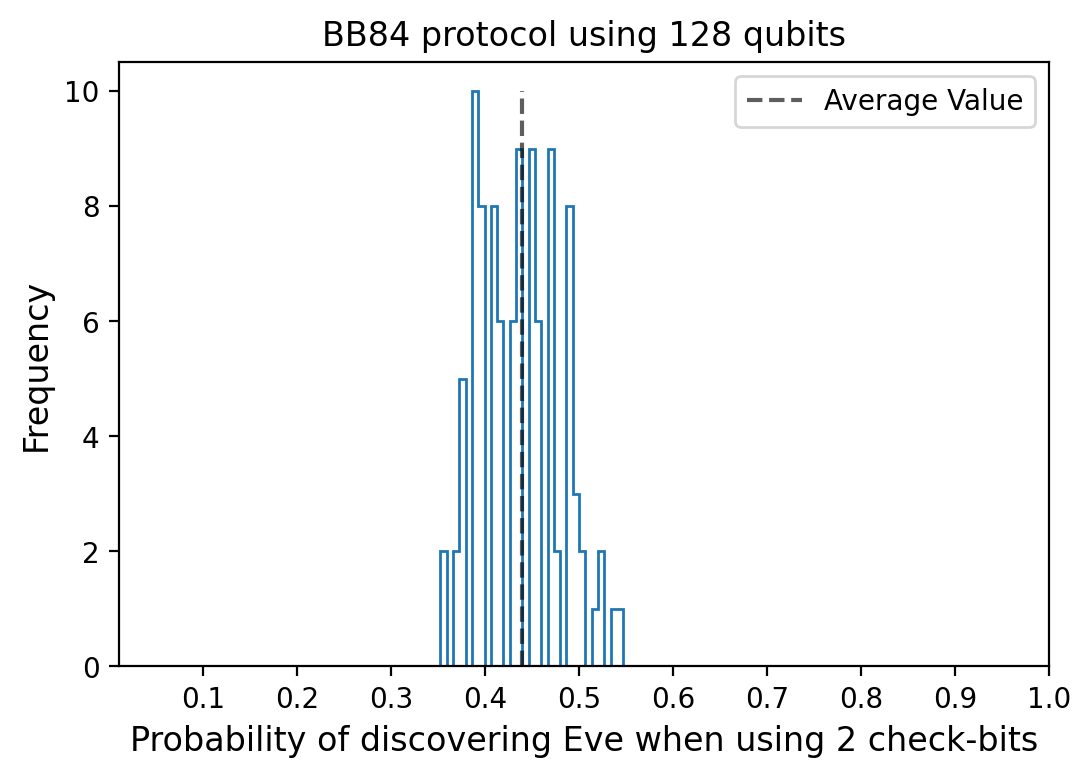

In [188]:
    
#Making 1 single plot
#Specifing qb changes the plot

qb=1
# qb is the amount of qubits to inspect UNLESS you changed the parameter lines at the simulation stage
# Keep in mind that python is 0-indexed  1 does NOT mean 1 qubit



plt.figure(num=qb,dpi=200)
count,val,_=plt.hist(dist[:,qb],bins=bins,align='left',histtype='step')
plt.vlines(x=avrg1[qb],ymin=0,ymax=max(count),label="Average Value",alpha=.63,linestyles='dashed')

plt.xticks(np.arange(start, stop+step, 2*step))
plt.legend()
plt.xlabel('Probability of discovering Eve when using %i check-bits' %N[qb],fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.xlim(0.01,1.0)
plt.title('BB84 protocol using %i qubits'%n)

plt.savefig(outpath+'/'+'BB84-dist with %i check-bits.png'%N[qb],dpi=200)
plt.show()
plt.close()

## For all plots individually

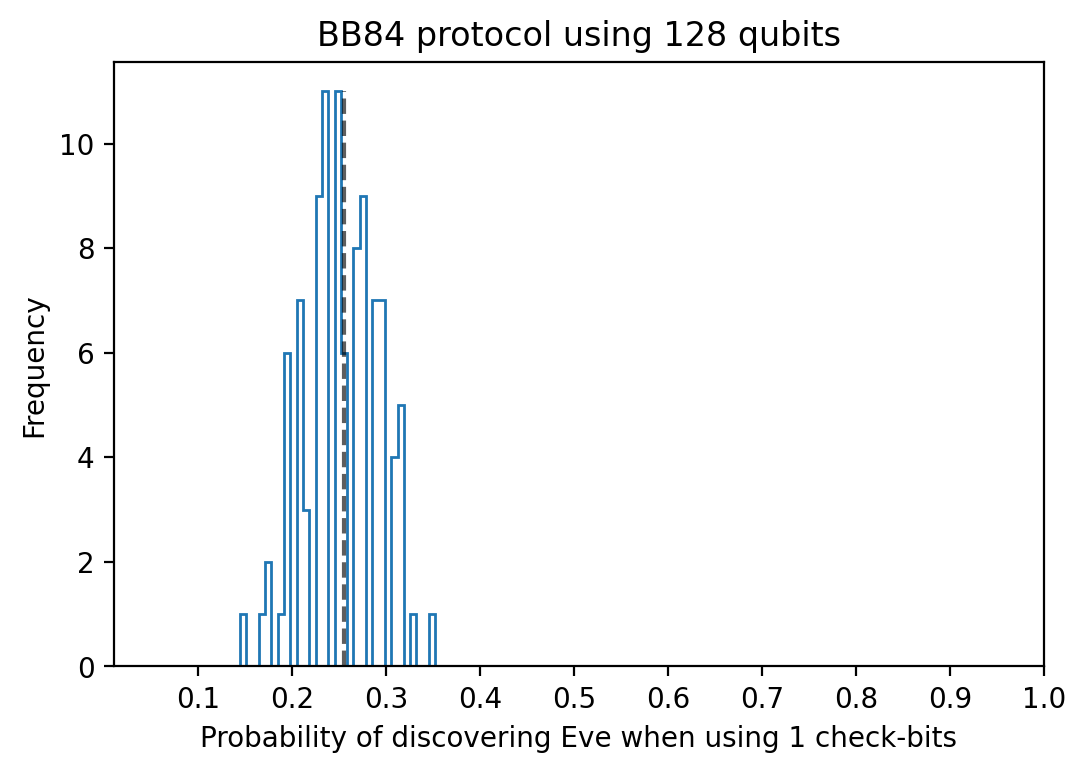

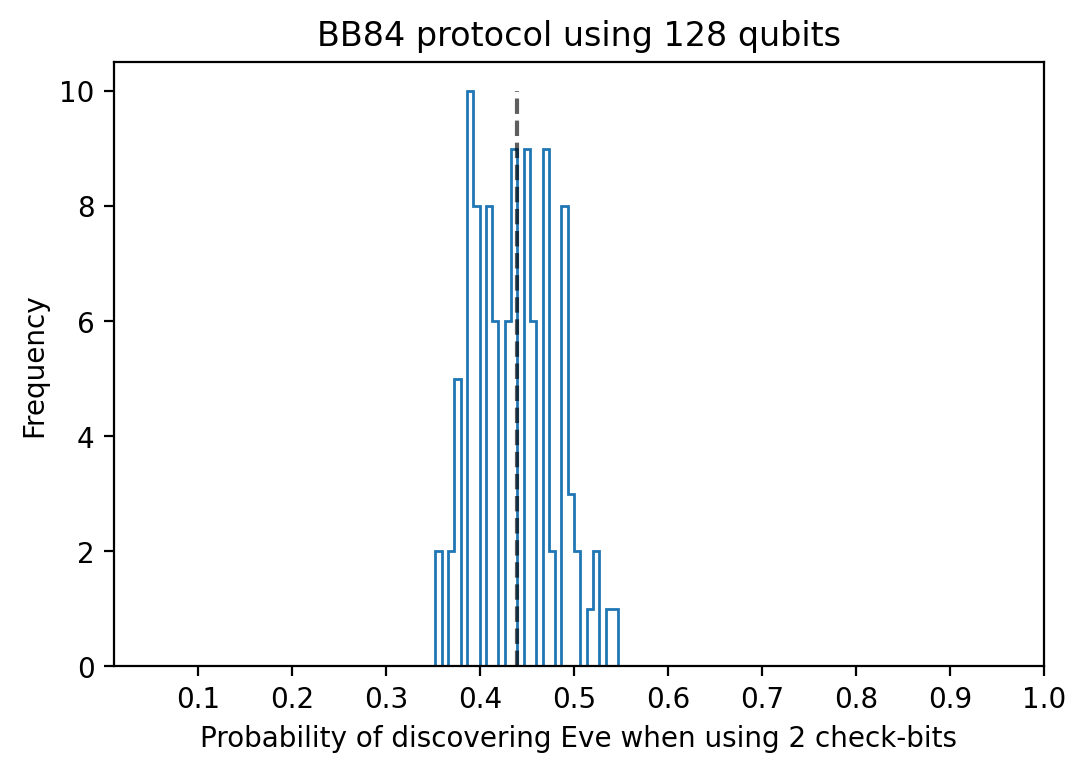

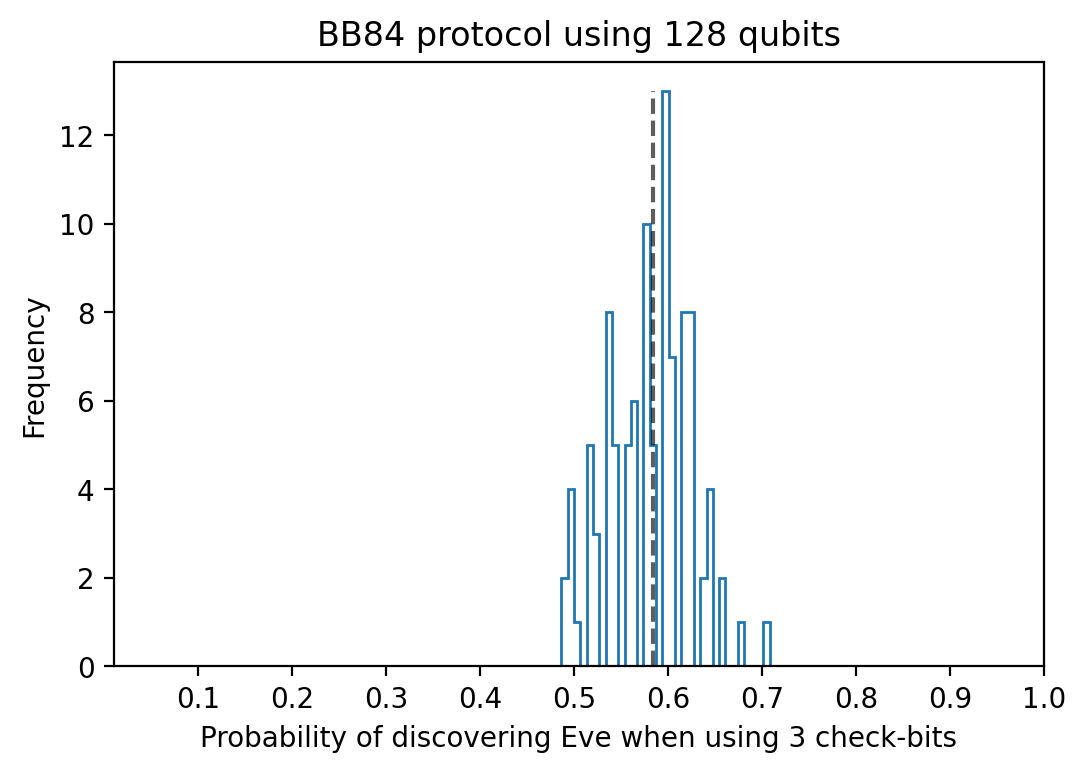

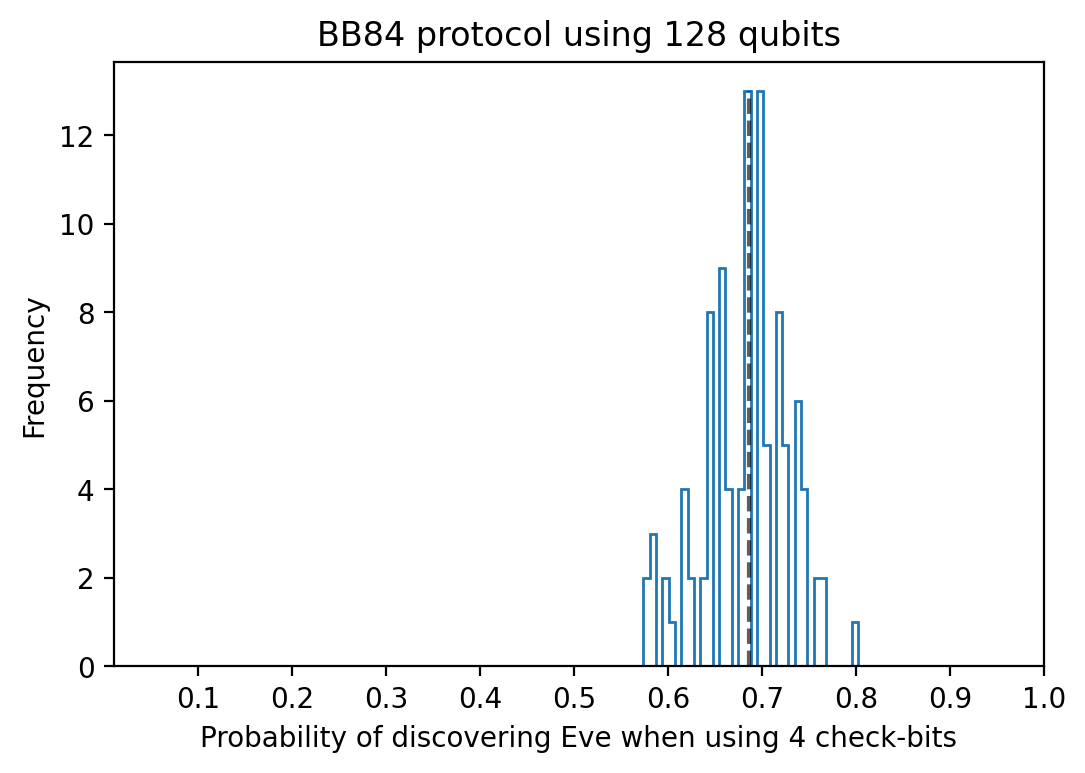

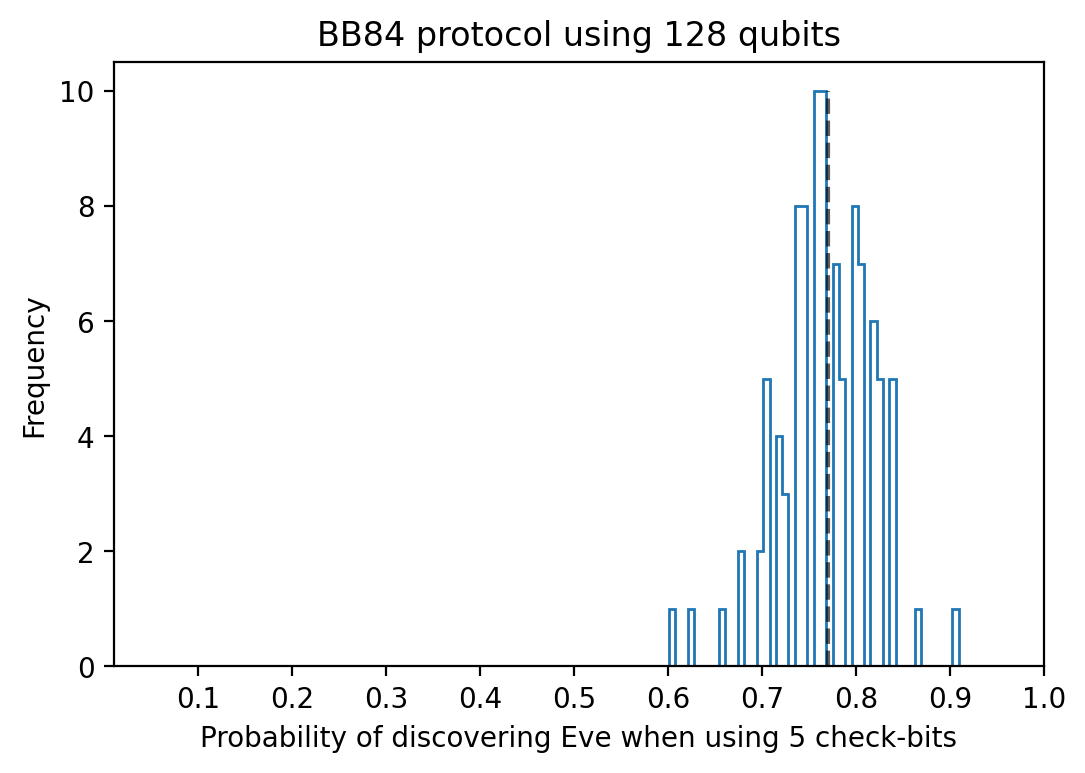

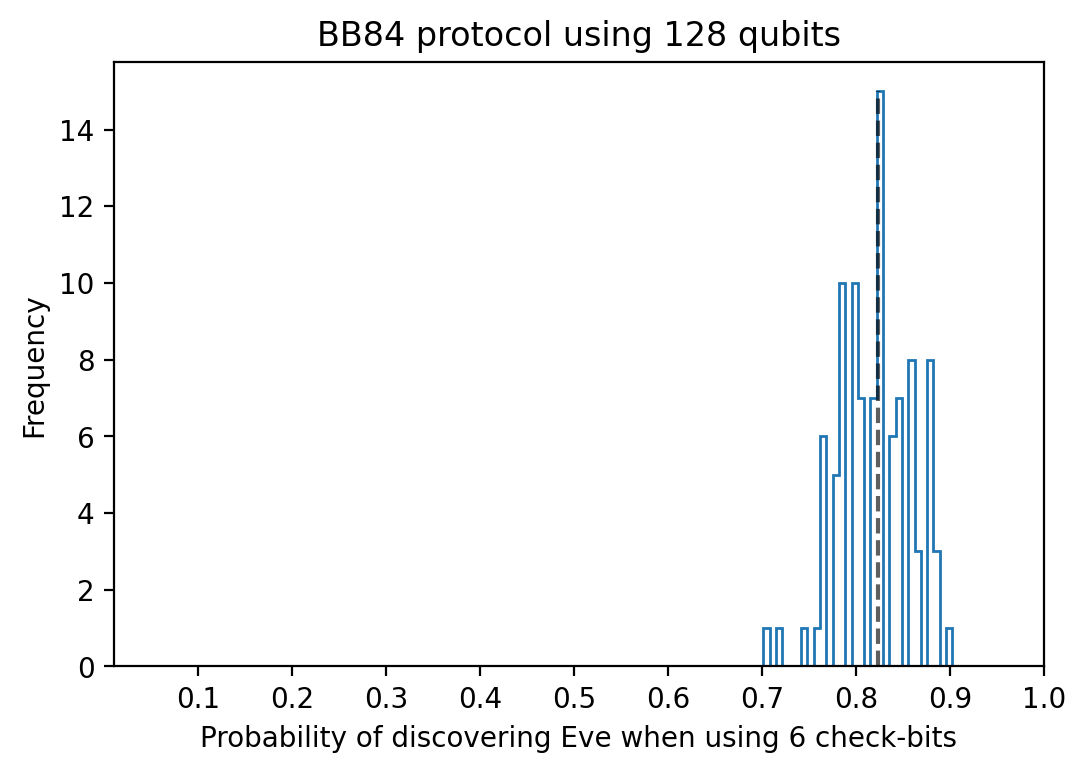

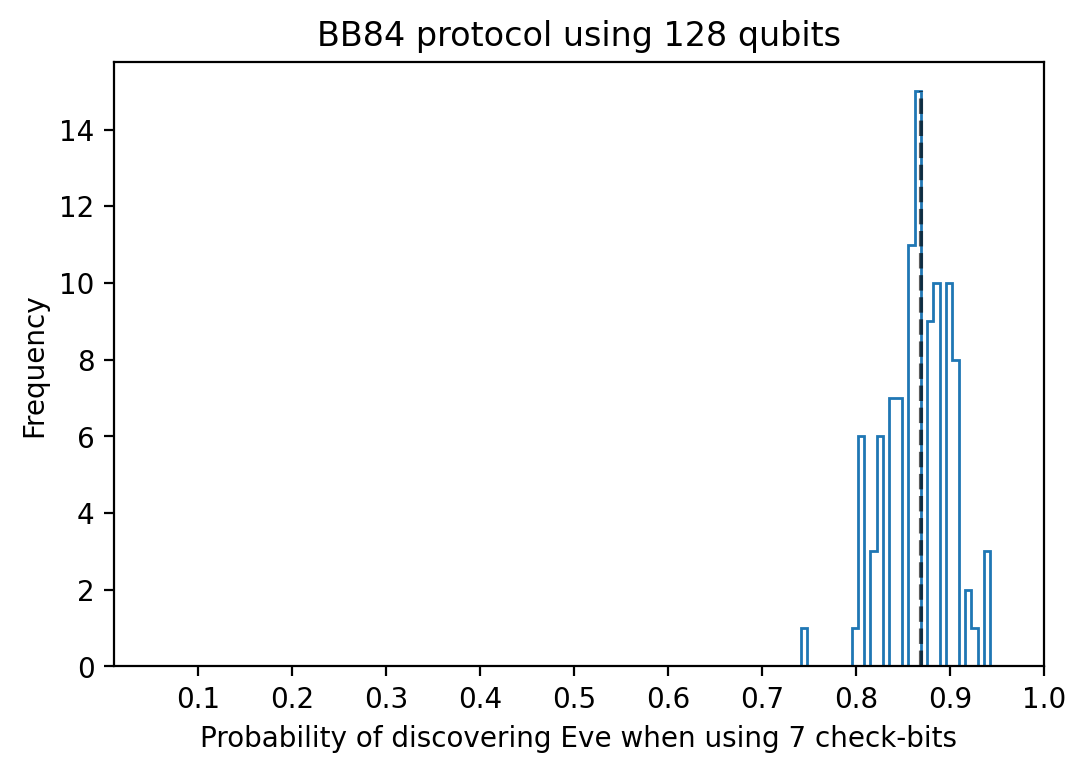

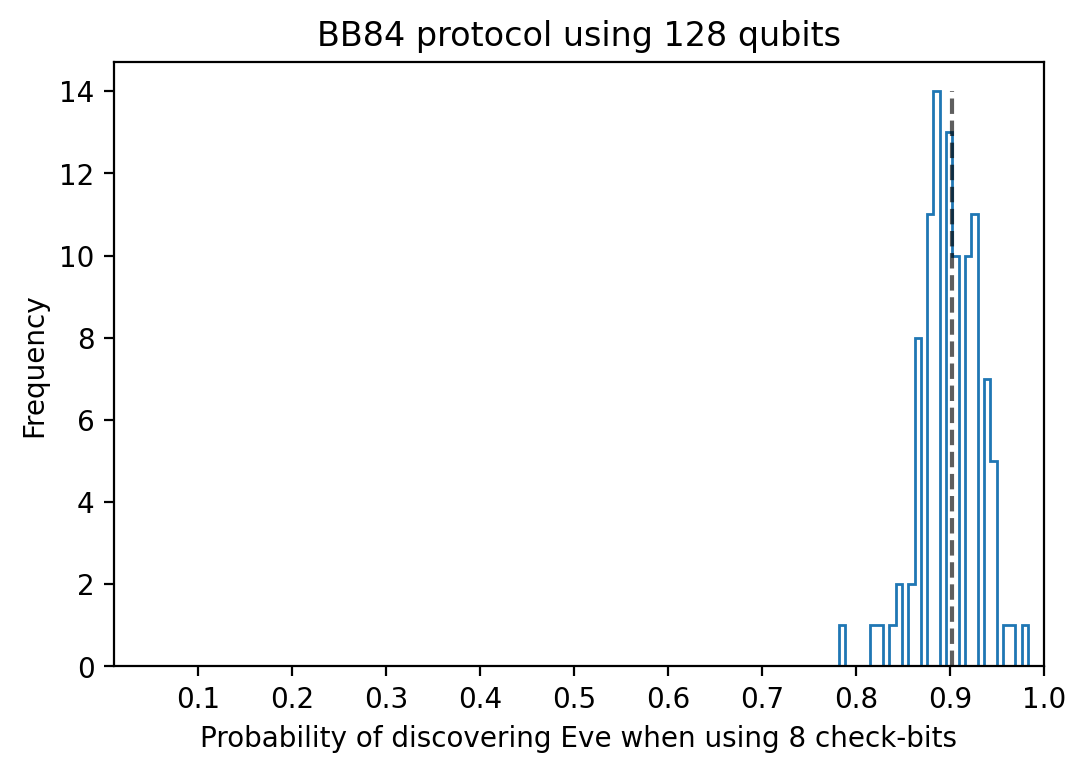

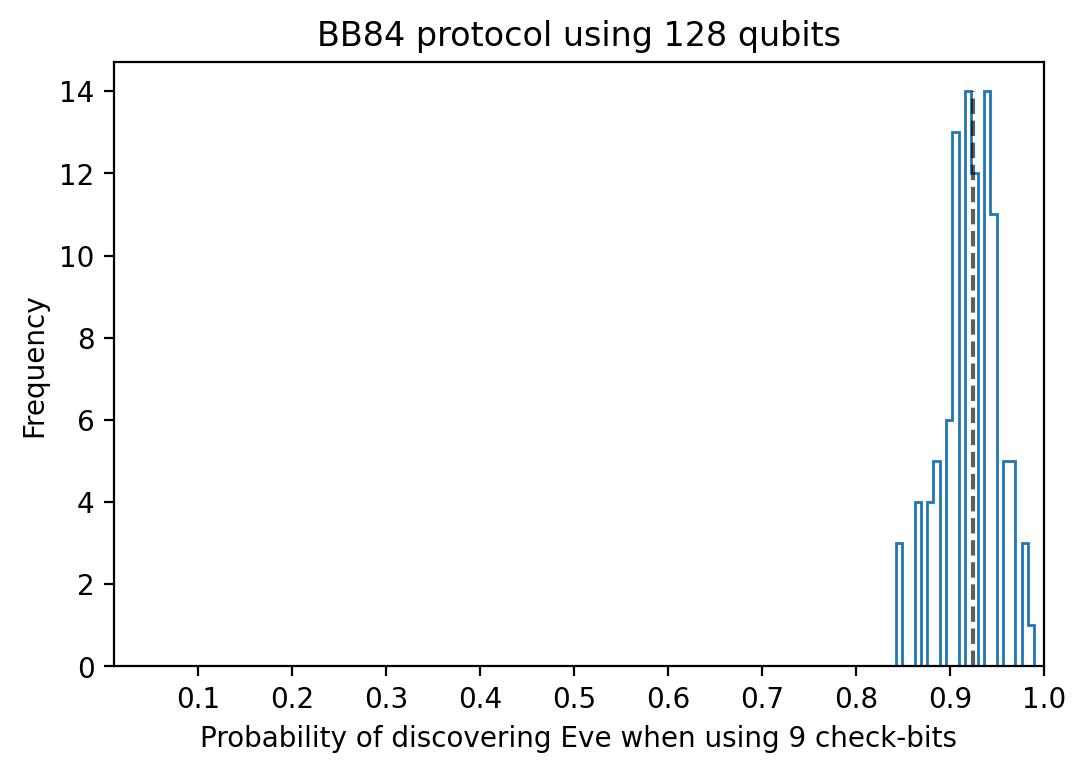

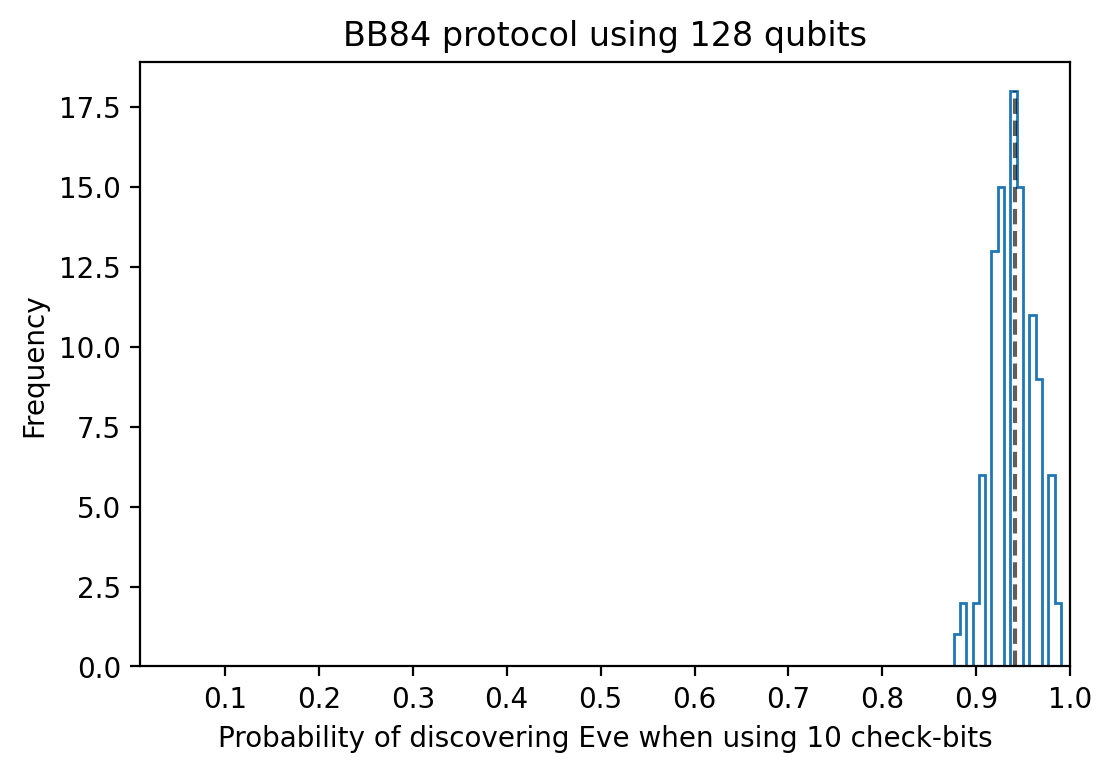

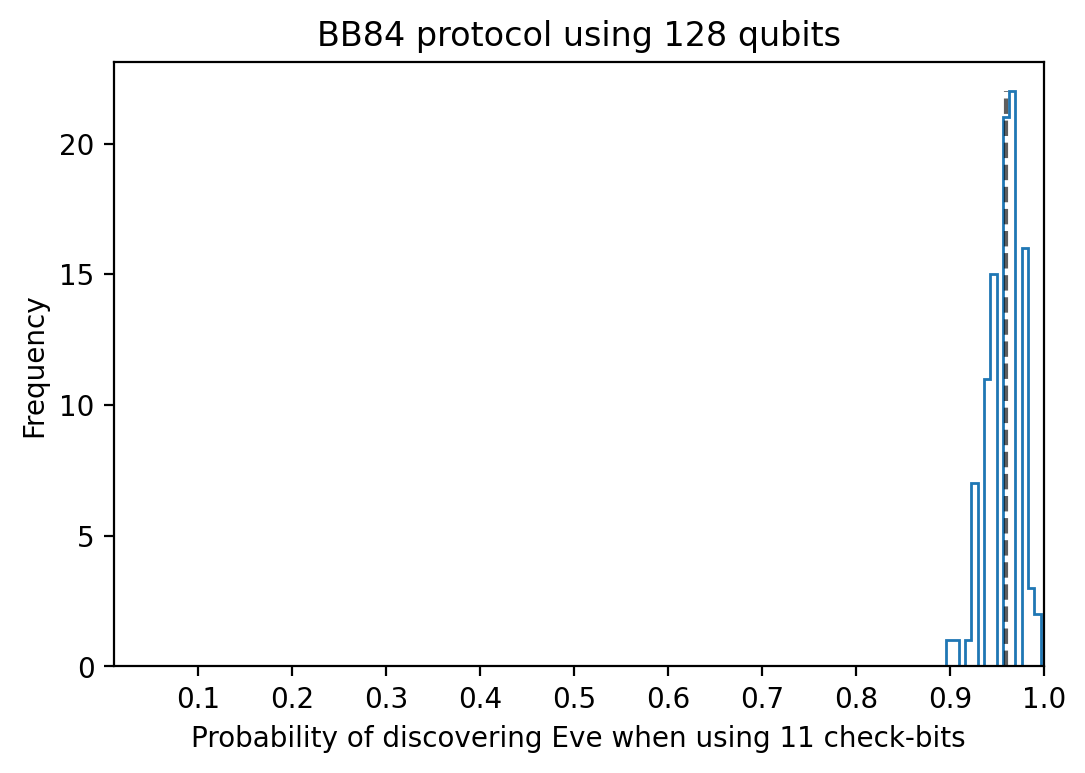

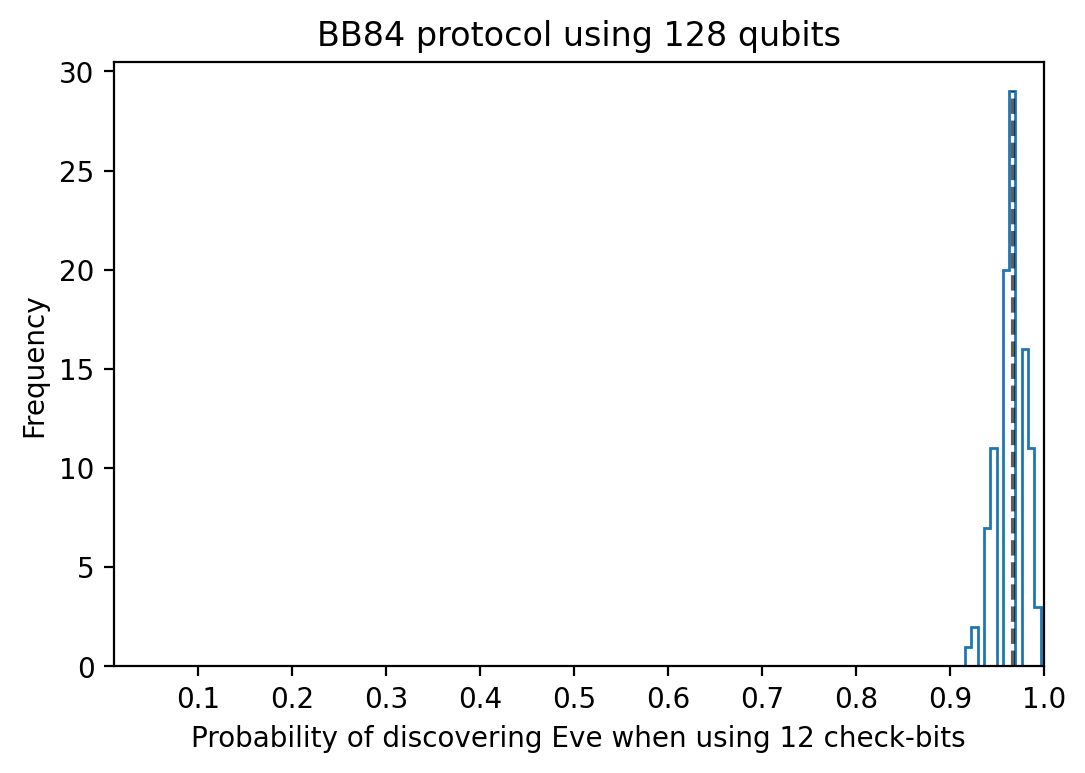

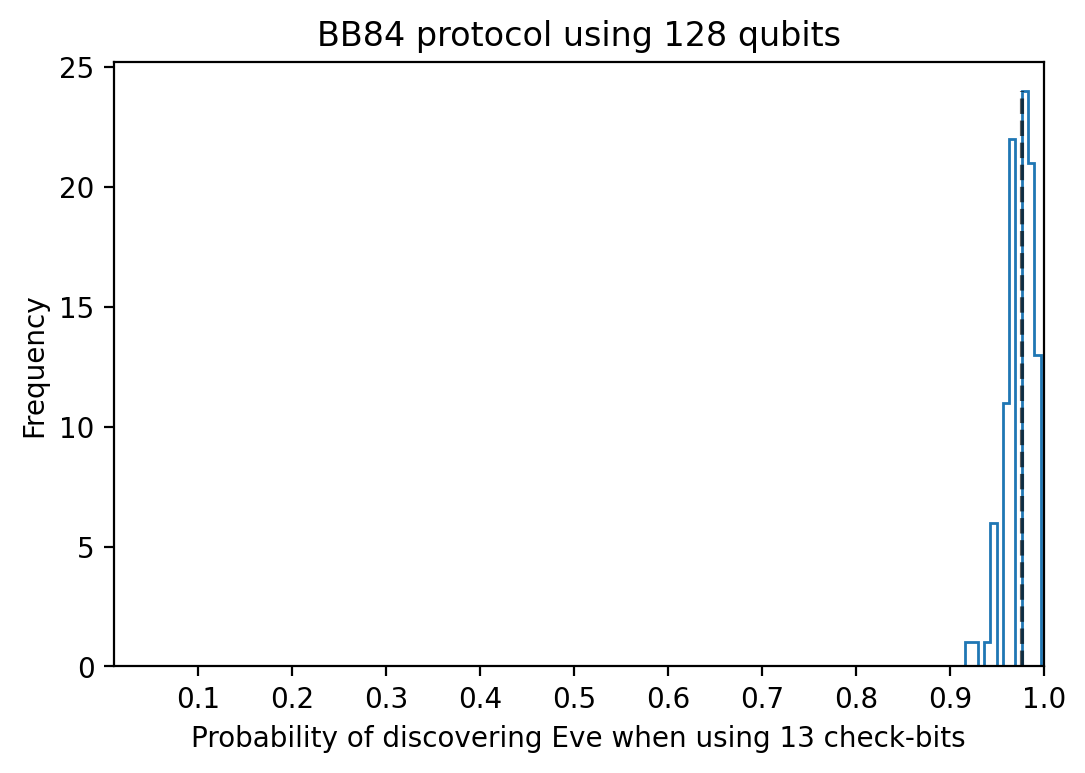

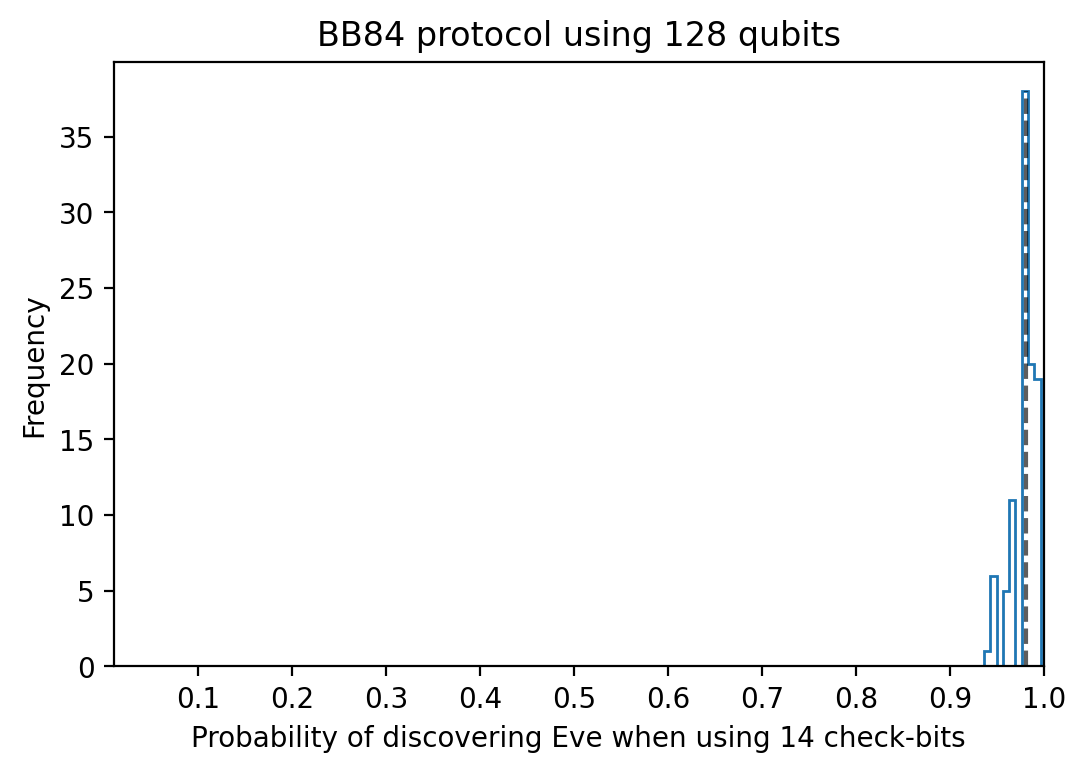

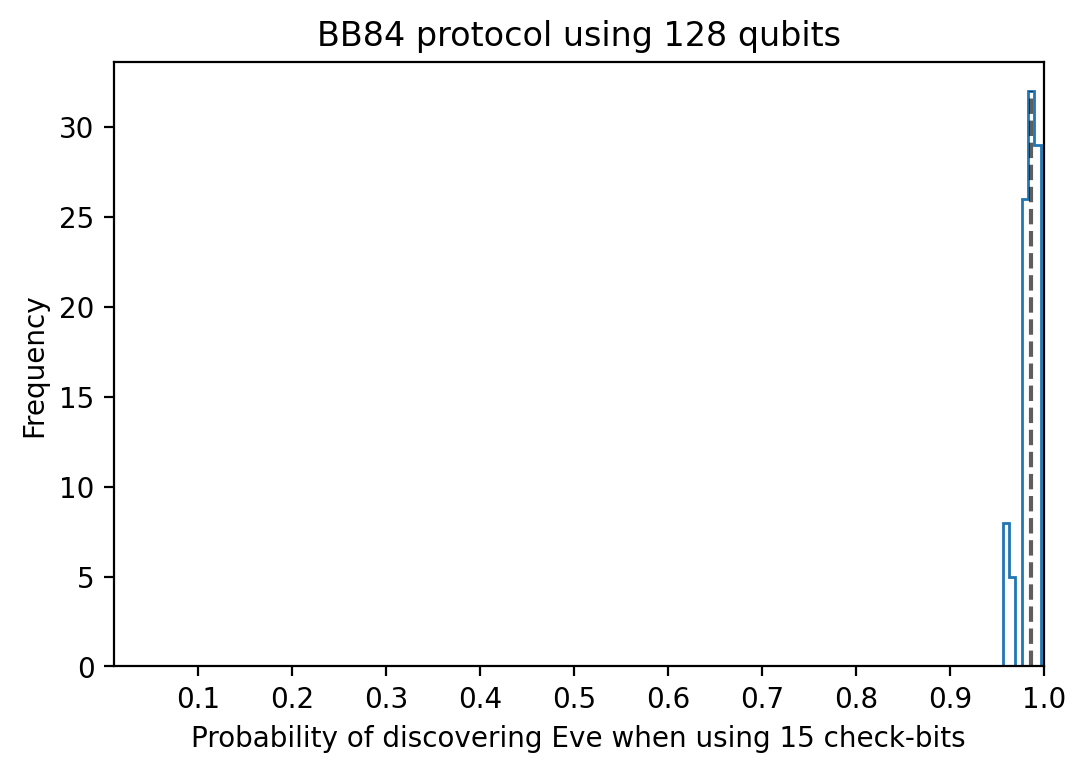

In [189]:
for qb in range(len(N)):
    count,val=[],[]
    plt.figure(num=qb,dpi=200)
    count,val,_=plt.hist(dist[:,qb],bins=bins,align='left',histtype='step' )
    plt.vlines(x=avrg1[qb],ymin=0,ymax=max(count),label="Average Value",linestyles="dashed",alpha=0.63)
    plt.xticks(np.arange(start, stop+step, 2*step))
    plt.xlabel('Probability of discovering Eve when using %i check-bits' %N[qb])
    plt.ylabel('Frequency')
    plt.xlim(0.01,1.0)
    plt.title('BB84 protocol using %i qubits'%n)
    plt.savefig(outpath+'/'+'BB84-dist with %i check-bits'%N[qb],dpi=200)
    plt.show()
    plt.close()

## This part is completely optional if you want a closer look at the individual distributions

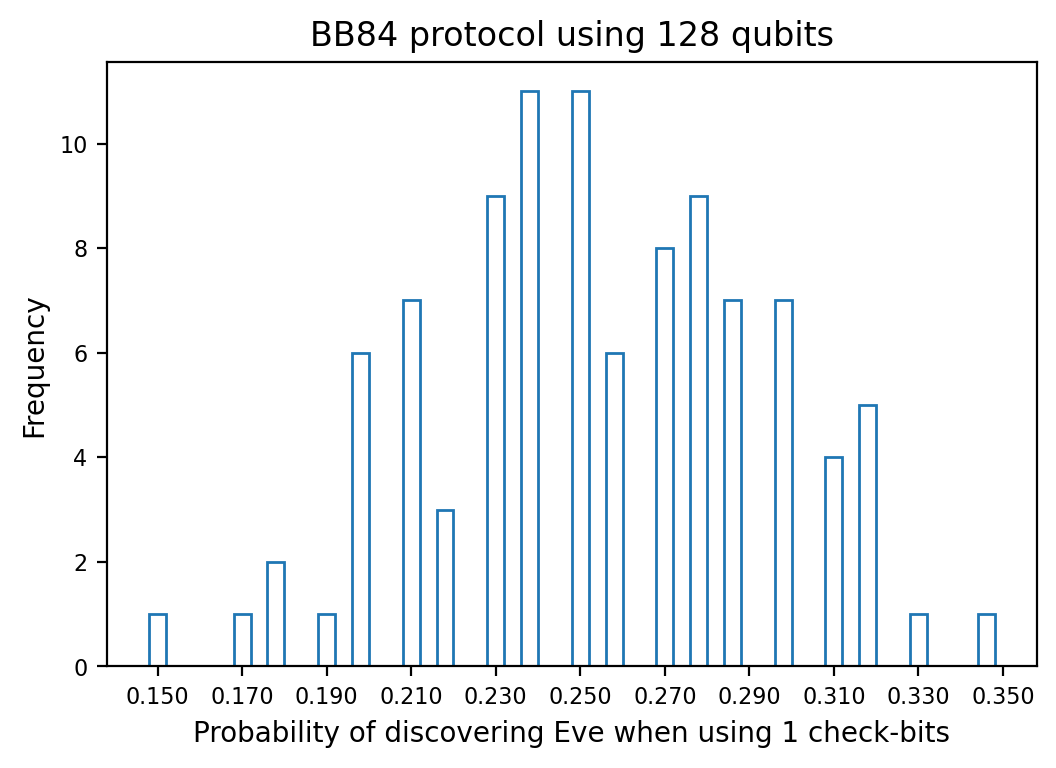

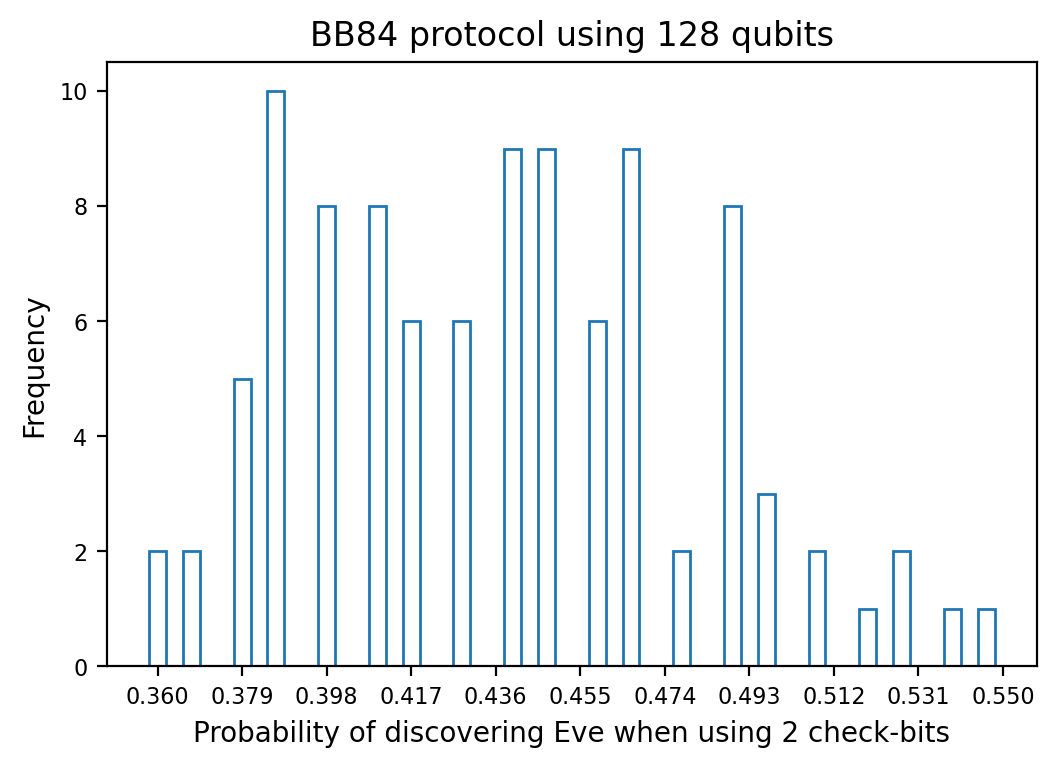

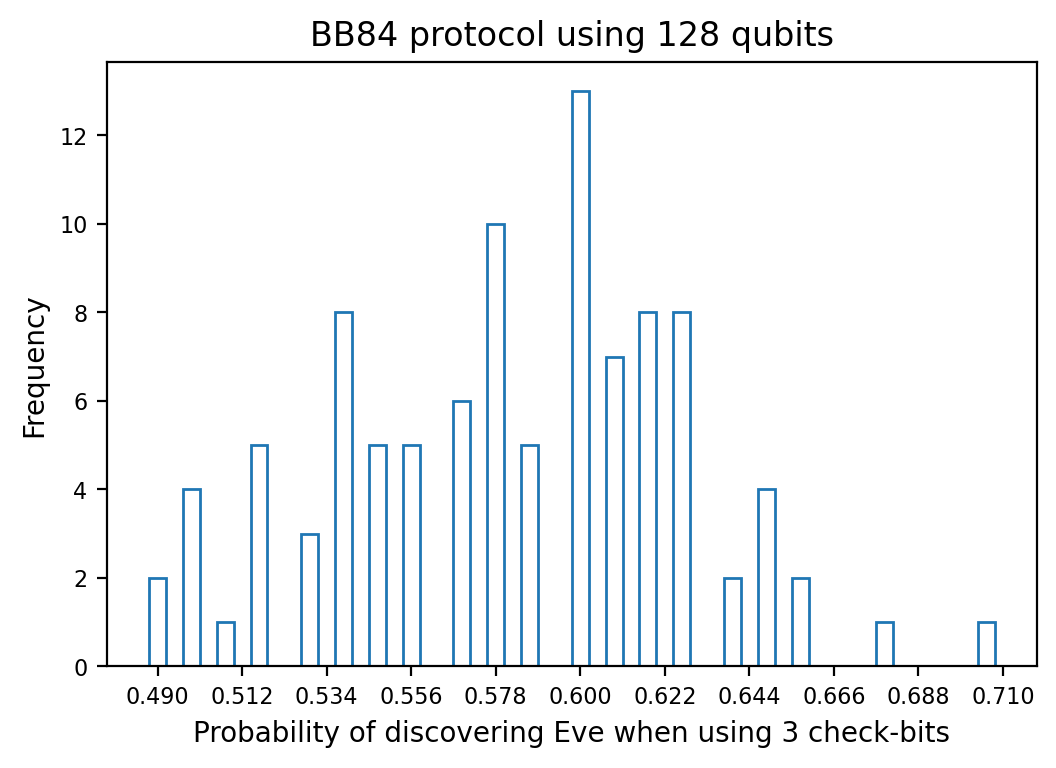

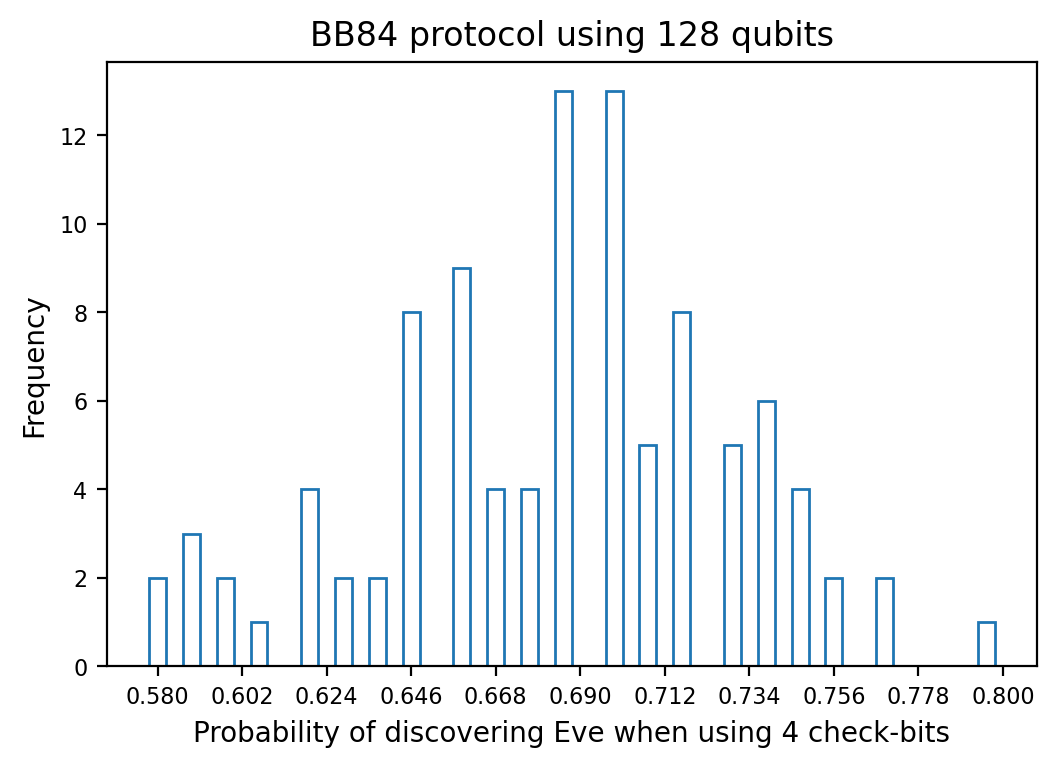

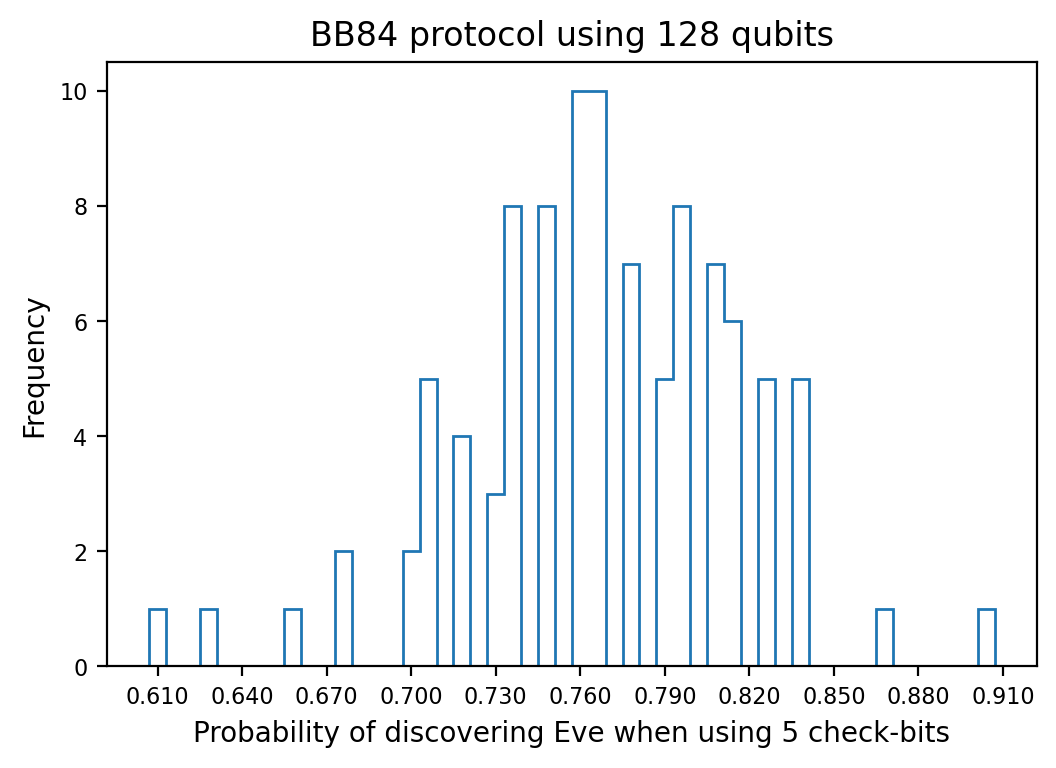

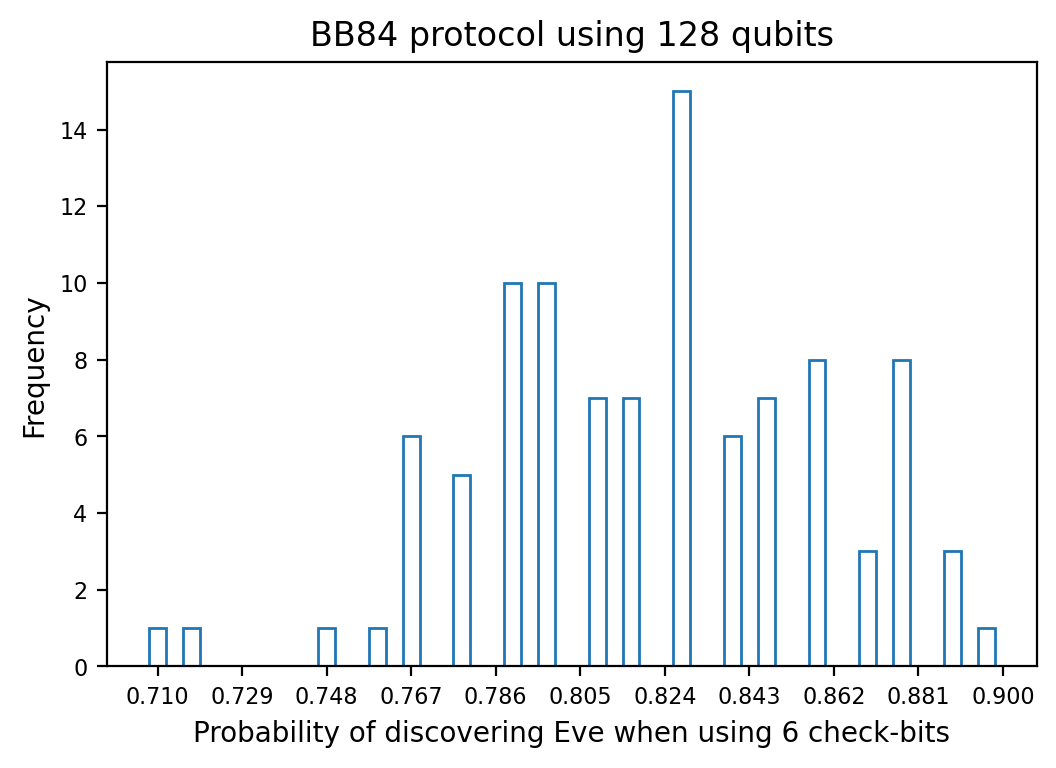

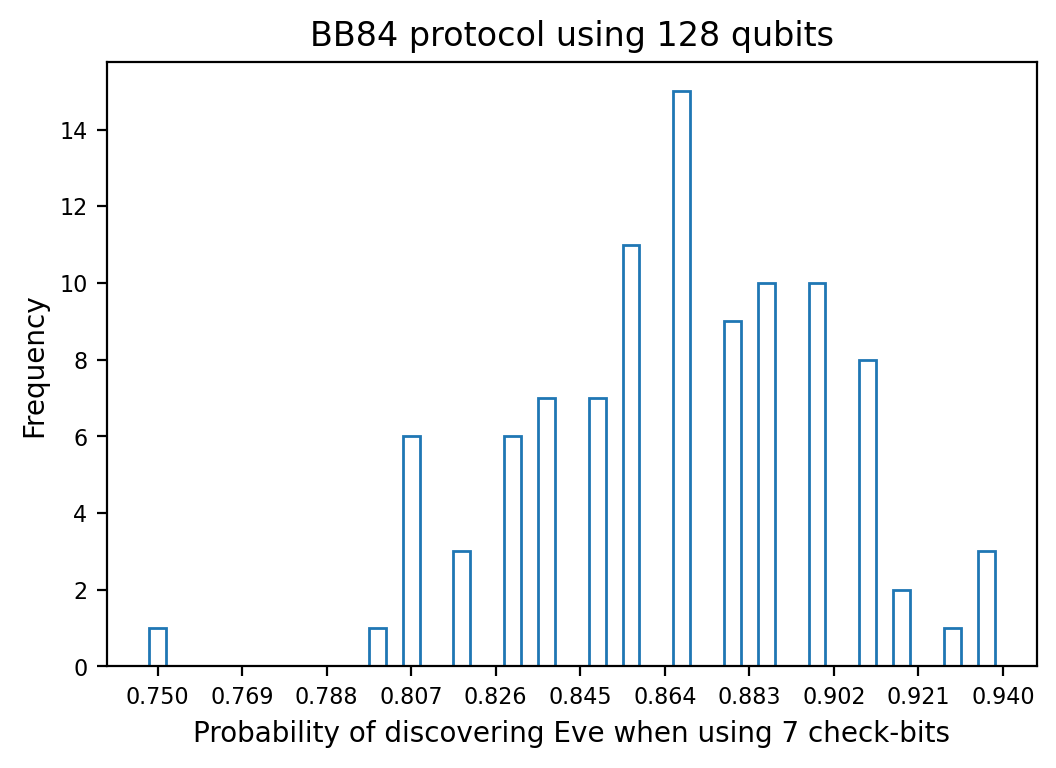

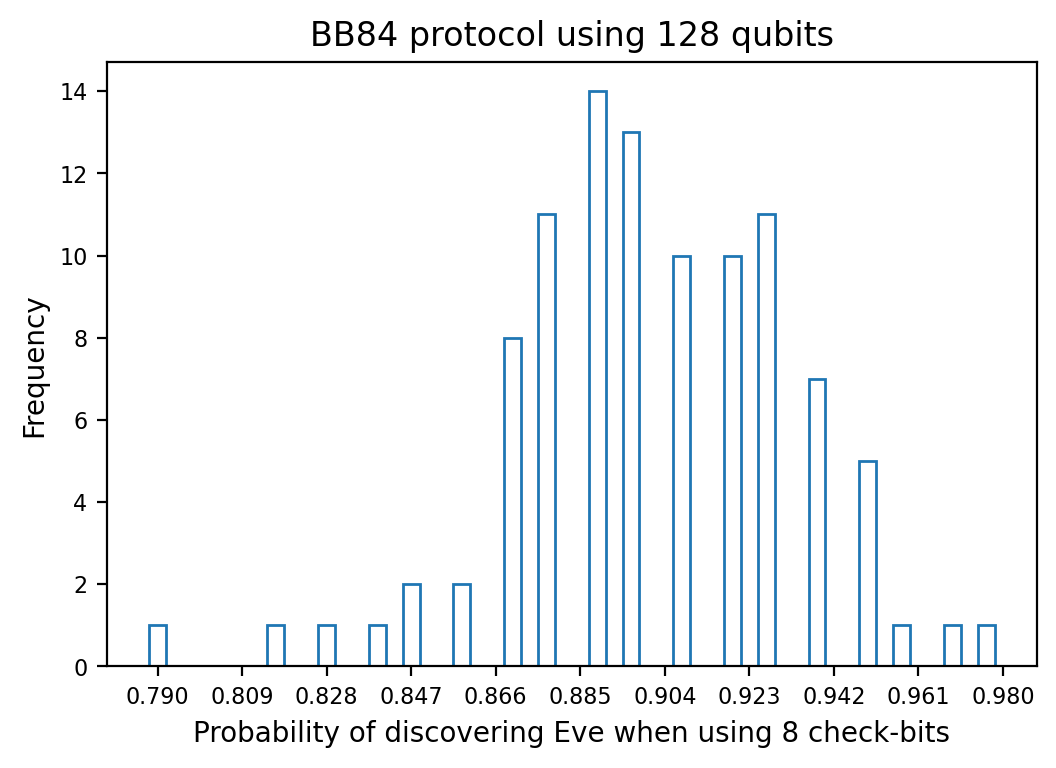

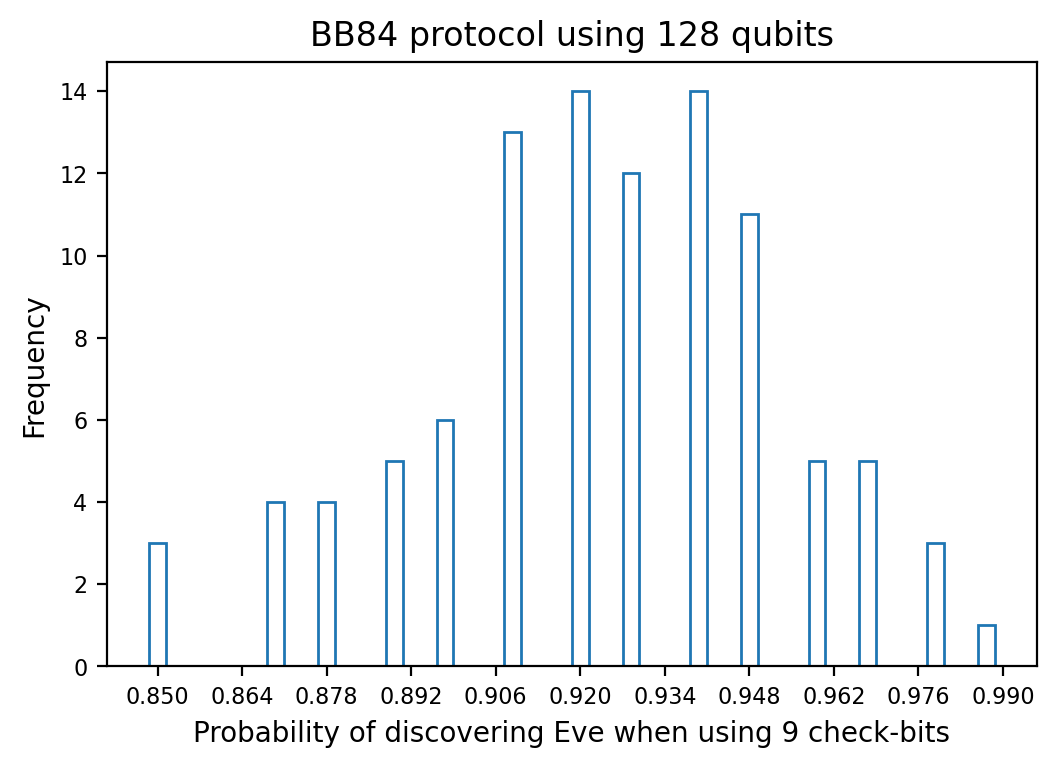

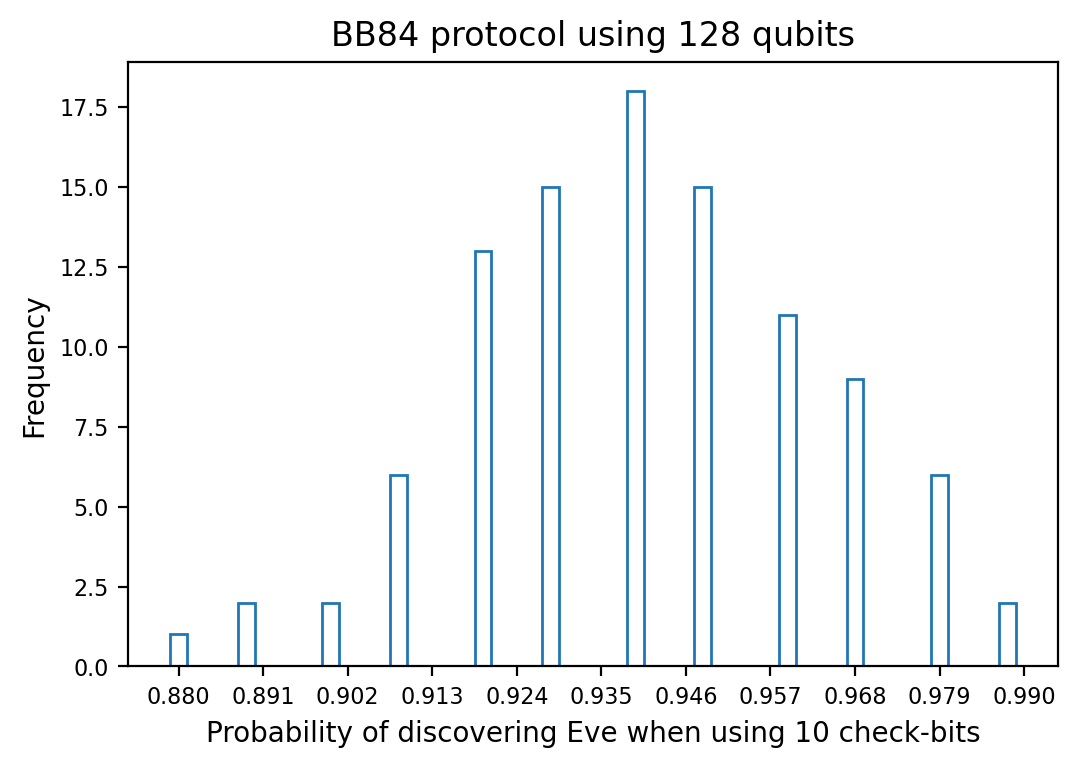

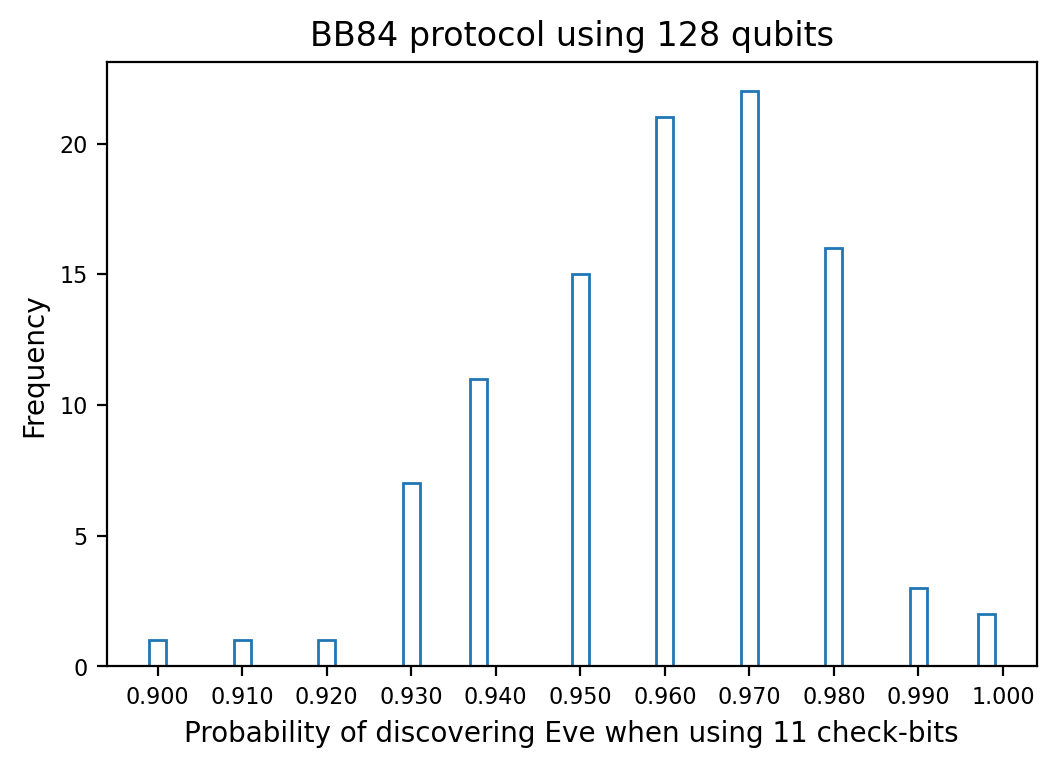

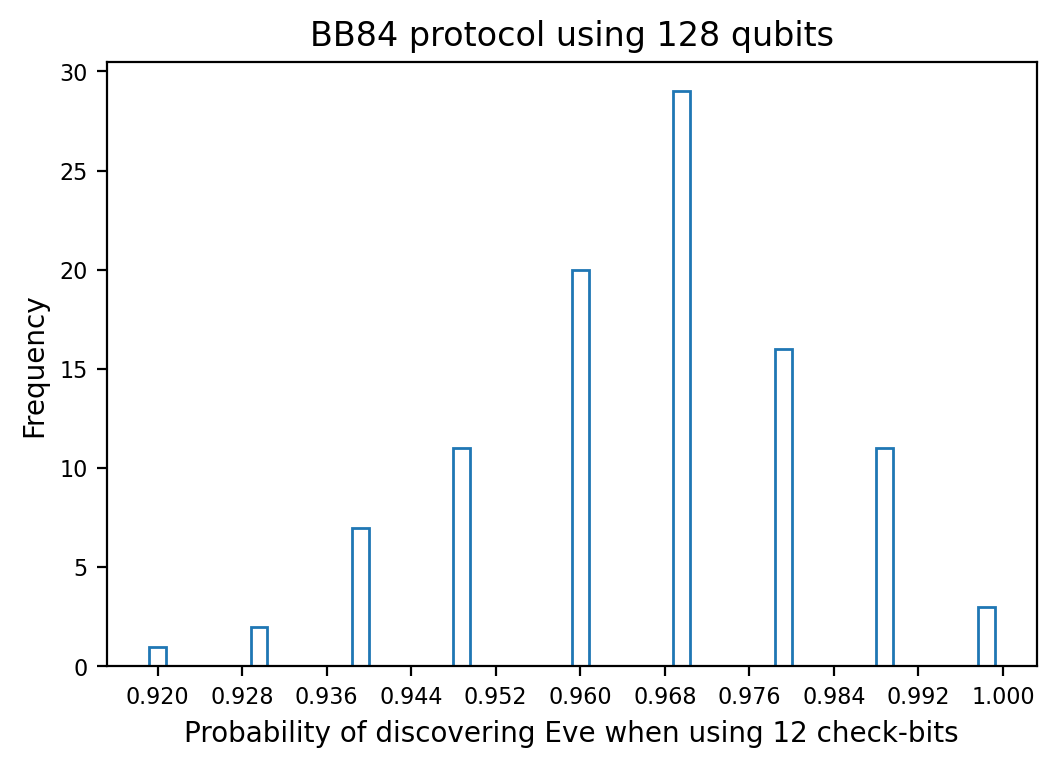

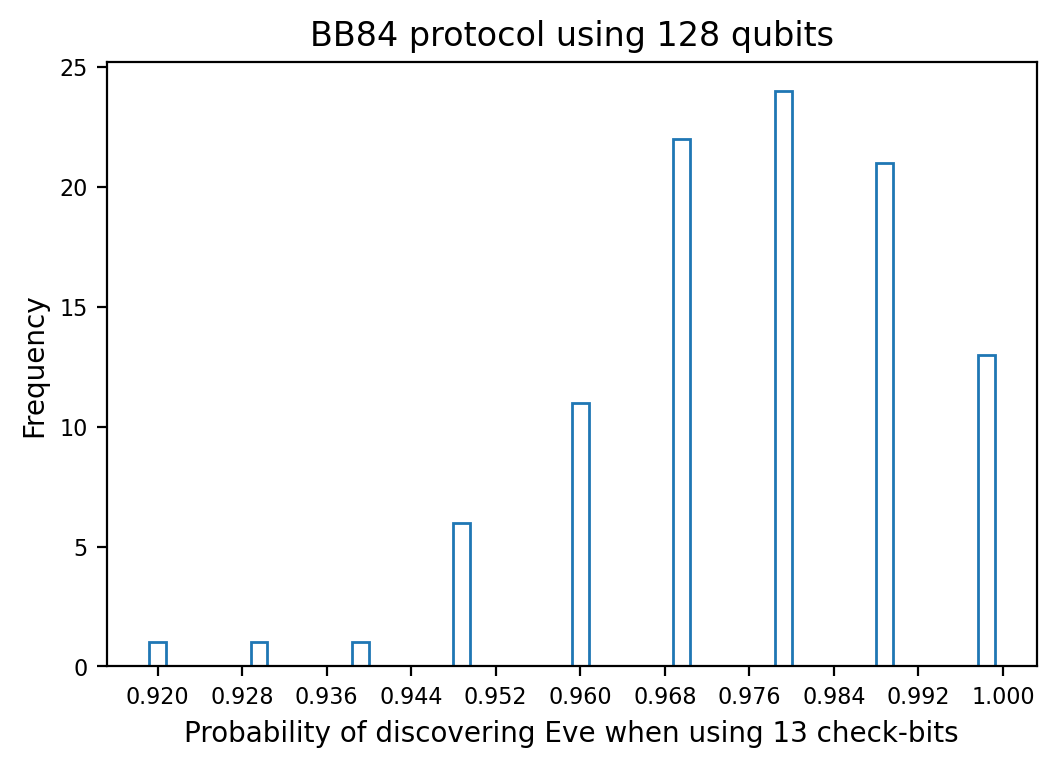

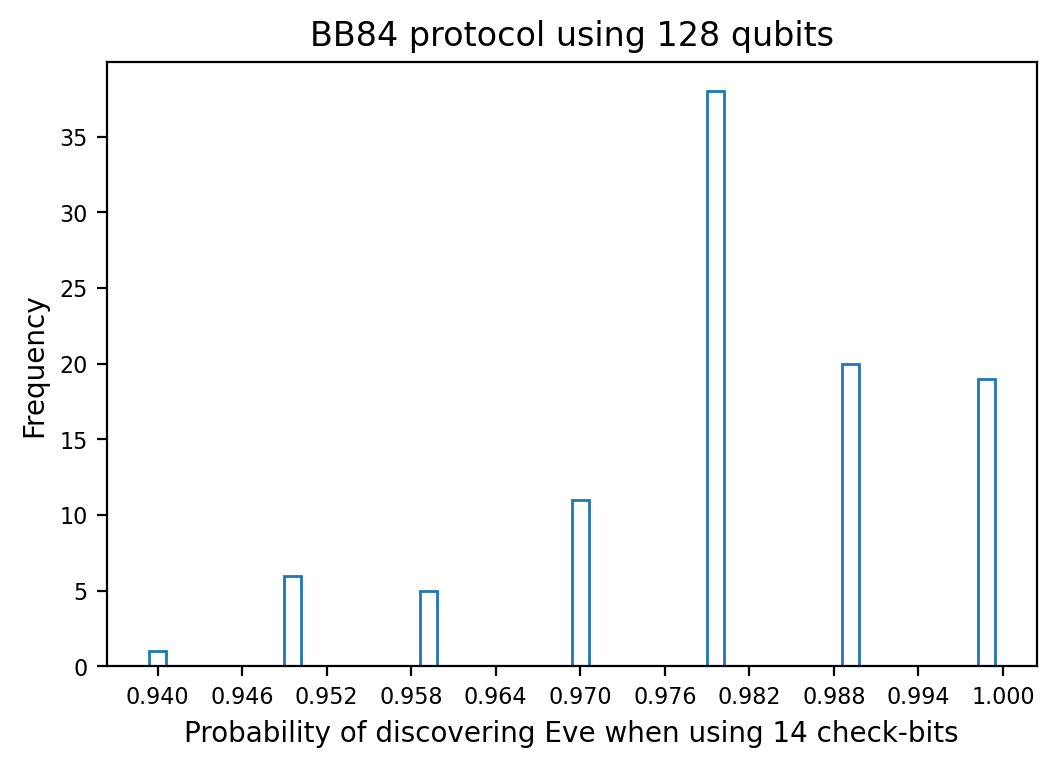

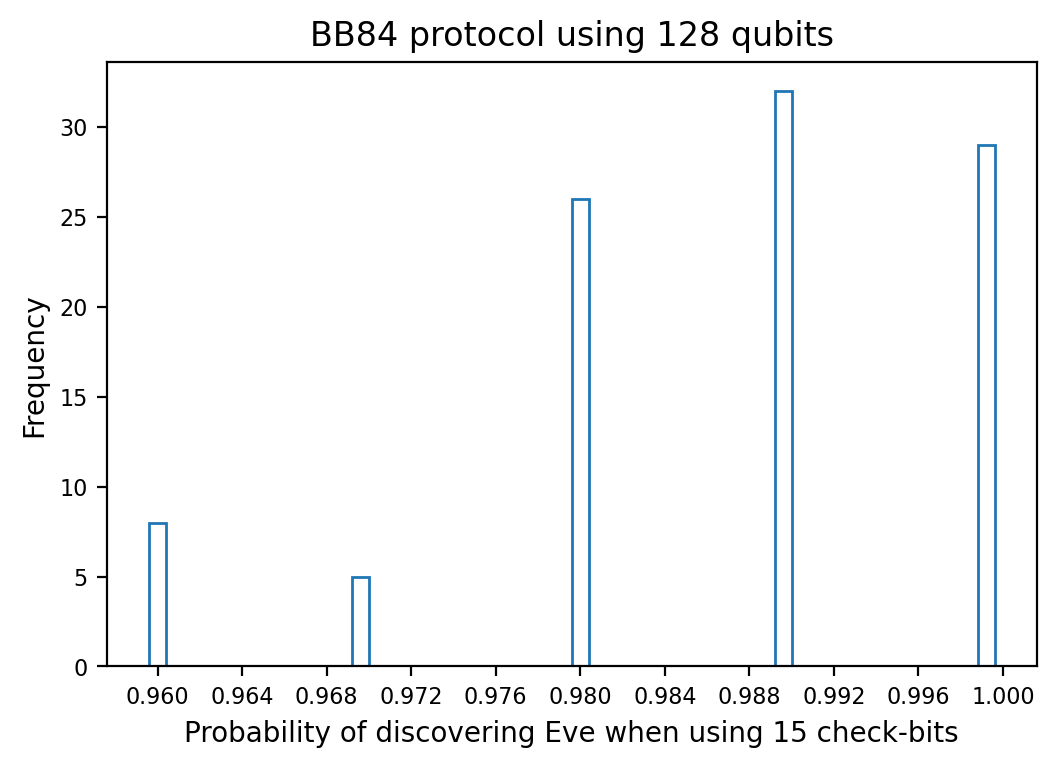

In [190]:
for qb in range(len(N)):
    count,val=[],[]
    plt.figure(num=qb,dpi=200)
    count,val,_=plt.hist(dist[:,qb],bins=50,align='left',histtype='step' )
    ll=['%.3f' %a for a in val]
    plt.xticks(ticks=val[::5],labels=ll[::5],fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel('Probability of discovering Eve when using %i check-bits' %N[qb])
    plt.ylabel('Frequency')
    plt.title('BB84 protocol using %i qubits'%n)
    plt.savefig(outpath+'/'+'CloserLook_BB84-dist with %i check-bits'%N[qb],dpi=200)
    plt.show()
    plt.close()

## A few of them together

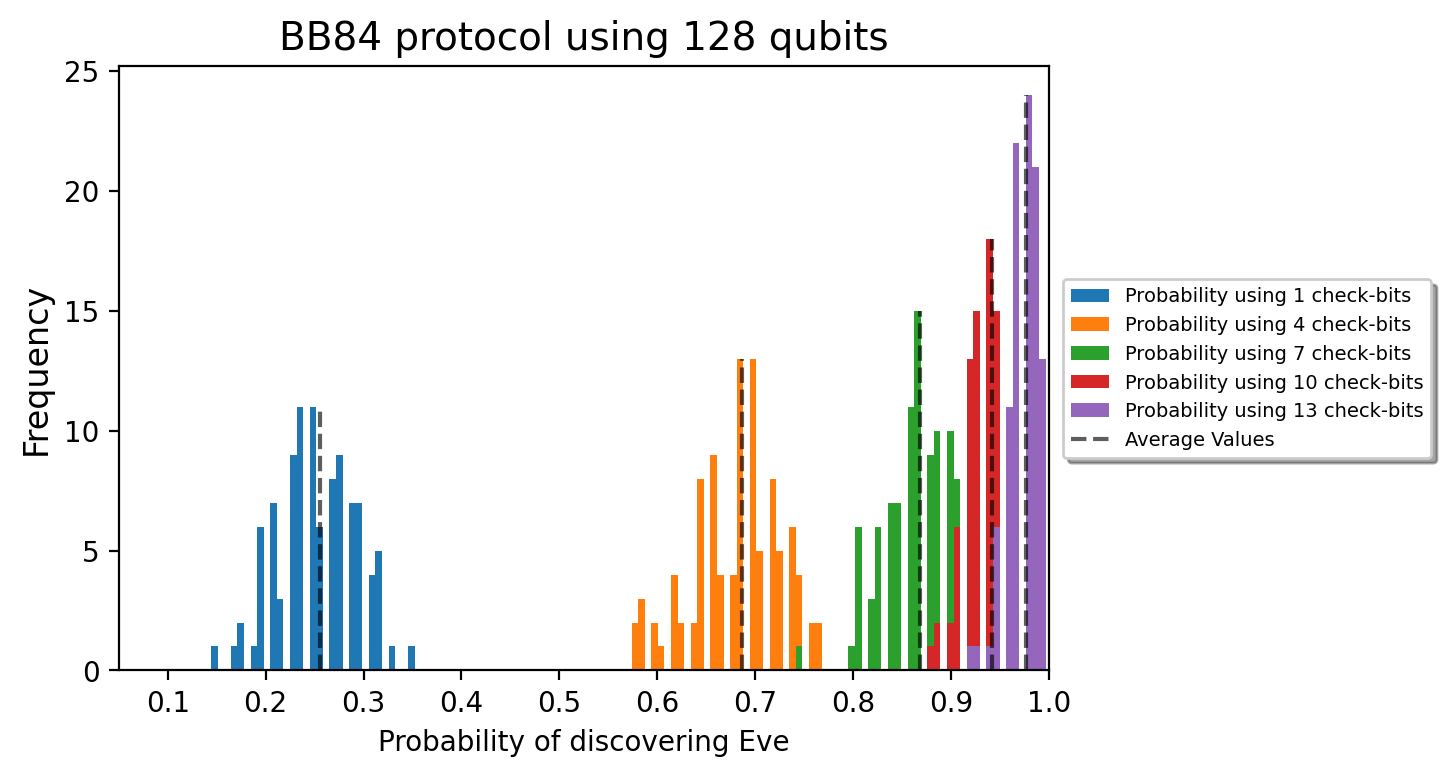

In [191]:
plt.figure(dpi=200)
start = 0
stop  = 1
step  = .05
bins=np.linspace(start, stop, num=150)

N=np.arange(1,16)

for qb in range(0,len(N),3):
    count,val,_=plt.hist(dist[:,qb],align='left',histtype='stepfilled',label='Probability using %i check-bits' %N[qb],bins=bins )
    plt.vlines(x=avrg1[qb],ymin=0,ymax=max(count), colors='k', linestyles='dashed',alpha=.63)

plt.vlines(x=avrg1[0],ymin=0,ymax=.001, colors='k', linestyles='dashed',  label='Average Values',alpha=.63)
plt.xticks(np.arange(start, stop+step, 2*step),fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Probability of discovering Eve',fontsize=10)
plt.ylabel('Frequency',fontsize=12)
plt.xlim(0.05,1.0)
# plt.grid(axis='x')
plt.legend(shadow=True,fontsize=7,bbox_to_anchor=(1.015,.5), loc="center left",borderaxespad=0)
plt.title('BB84 protocol using %i qubits'%n , fontsize=14)
plt.savefig(outpath+'/'+'BB84-dist-superimposed',dpi=200,bbox_inches="tight")
plt.show()
plt.close()

In [192]:
# print(p)
N1=np.arange(1,16)
P=1-(.75)**N1
print(P)
# print(np.e)

[0.25       0.4375     0.578125   0.68359375 0.76269531 0.82202148
 0.86651611 0.89988708 0.92491531 0.94368649 0.95776486 0.96832365
 0.97624274 0.98218205 0.98663654]


## Errors between our theoretical values and our simulation values for the probabilities of detecting Eve

In [193]:
# Root Squared error
rse=np.sqrt((avrg1-P)**2)
# print('root squared error: \n',rse)

# Difference 
Error=avrg1-P
# print("Error: \n",Error)

# Absolute Error
abserr=np.abs(avrg1-P)
# print('absolute error: \n',abserr)
# print('\nIs root squared error same as absolute error?:\n', rse==abserr)


# Percentage Error
percenterr=(abserr/P)*100
print('\n    Percentage of Error       Absolute Error')
count=1
for i,x in zip(percenterr,abserr):
    print(str(count)+') \t'+'%.4f' %i+' %'+'\t\t %.4f' %x)
    count+=1
# print(percenterr)


    Percentage of Error       Absolute Error
1) 	2.2000 %		 0.0055
2) 	0.3657 %		 0.0016
3) 	0.9816 %		 0.0057
4) 	0.3959 %		 0.0027
5) 	0.9971 %		 0.0076
6) 	0.1312 %		 0.0011
7) 	0.2636 %		 0.0023
8) 	0.3126 %		 0.0028
9) 	0.0341 %		 0.0003
10) 	0.2317 %		 0.0022
11) 	0.2125 %		 0.0020
12) 	0.1264 %		 0.0012
13) 	0.0776 %		 0.0008
14) 	0.0694 %		 0.0007
15) 	0.0267 %		 0.0003


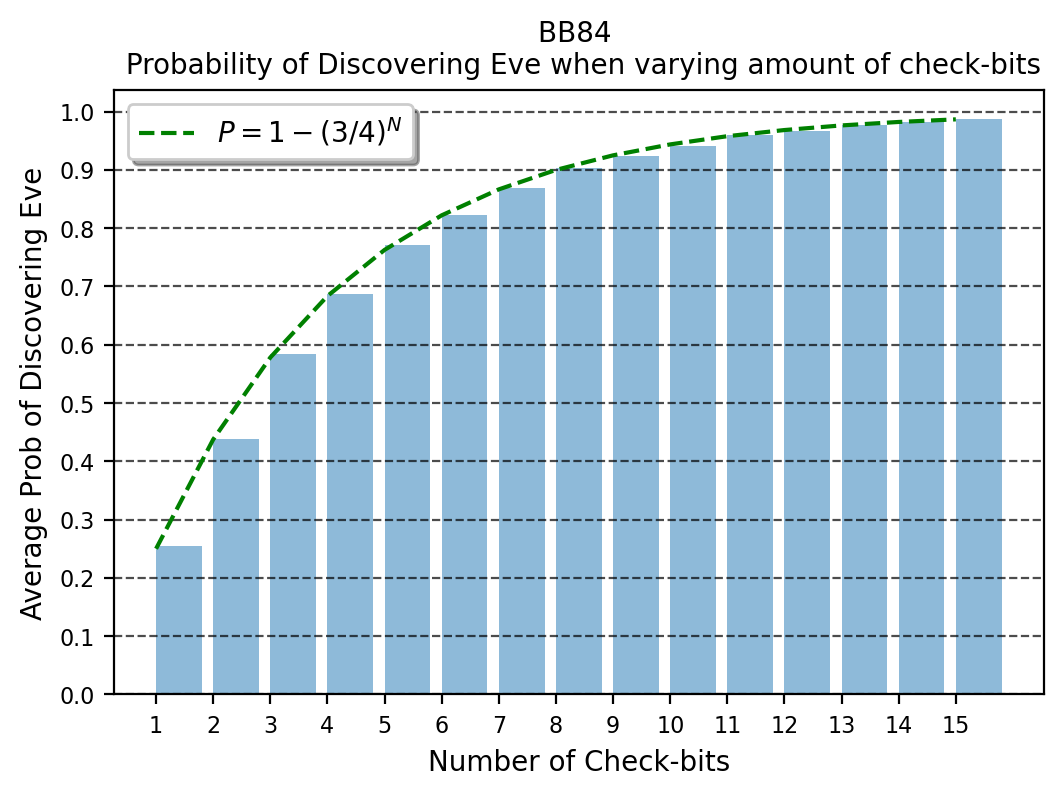

In [194]:
plt.figure(dpi=200)
plt.bar(N,avrg1,alpha=.5,align='edge')
# plt.plot(N,avrg,'ok',label='Simulation')
plt.plot(N,P,'--g',label='$P=1-(3/4)^N$')
plt.xticks(ticks=N,fontsize=8)
plt.yticks(ticks=np.arange(start,stop+step,2*step),fontsize=8)
plt.xlabel('Number of Check-bits',fontsize=10)
plt.ylabel('Average Prob of Discovering Eve',fontsize=10)
plt.title('BB84 \n Probability of Discovering Eve when varying amount of check-bits', fontsize=10)
plt.legend(fontsize=10,loc='upper left',shadow=True)
plt.grid(axis='y',color='k',linestyle='--',alpha=.7)
plt.savefig(outpath+'/'+'BB84-prob-per-Check-bits.png',dpi=200)
plt.show()
plt.close()

# We also have a CSV file with data from a more precise simulation

We won't need to run a sim each time you need to look a the plots or generate other plots

We can use pandas to read the CSV file provided in the Github Repo

In [195]:
import pandas as pd

## Configuration of the plots

In [196]:
df=pd.read_csv('Distribution-Data-for-BB84.csv')
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.234,0.429,0.585,0.675,0.747,0.833,0.850,0.910,0.927,0.942,0.956,0.961,0.981,0.989,0.985
1,0.257,0.453,0.565,0.701,0.753,0.823,0.857,0.882,0.926,0.944,0.950,0.958,0.981,0.978,0.993
2,0.251,0.393,0.564,0.685,0.742,0.813,0.859,0.879,0.923,0.935,0.943,0.959,0.973,0.985,0.980
3,0.248,0.421,0.569,0.659,0.792,0.831,0.870,0.905,0.920,0.948,0.946,0.961,0.977,0.986,0.983
4,0.246,0.450,0.574,0.701,0.753,0.827,0.883,0.900,0.926,0.942,0.951,0.966,0.968,0.982,0.985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.258,0.425,0.562,0.697,0.750,0.824,0.865,0.896,0.921,0.950,0.956,0.967,0.981,0.981,0.984
996,0.250,0.437,0.559,0.679,0.769,0.812,0.878,0.904,0.934,0.945,0.962,0.973,0.980,0.986,0.986
997,0.252,0.423,0.574,0.681,0.762,0.825,0.867,0.894,0.926,0.937,0.971,0.978,0.973,0.980,0.987
998,0.241,0.439,0.559,0.679,0.763,0.820,0.877,0.907,0.925,0.925,0.952,0.965,0.980,0.981,0.992


## Here we see some statistics of the simulation

In [197]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       1000 non-null   float64
 1   2       1000 non-null   float64
 2   3       1000 non-null   float64
 3   4       1000 non-null   float64
 4   5       1000 non-null   float64
 5   6       1000 non-null   float64
 6   7       1000 non-null   float64
 7   8       1000 non-null   float64
 8   9       1000 non-null   float64
 9   10      1000 non-null   float64
 10  11      1000 non-null   float64
 11  12      1000 non-null   float64
 12  13      1000 non-null   float64
 13  14      1000 non-null   float64
 14  15      1000 non-null   float64
dtypes: float64(15)
memory usage: 117.2 KB
None


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.250526,0.437693,0.578709,0.683454,0.763142,0.822009,0.866799,0.899874,0.925166,0.944141,0.957511,0.968614,0.976102,0.982232,0.986593
std,0.013575,0.015157,0.014875,0.015038,0.013458,0.012421,0.010738,0.009407,0.008191,0.007446,0.006423,0.005409,0.004827,0.004178,0.003575
min,0.209000,0.385000,0.536000,0.640000,0.723000,0.777000,0.830000,0.862000,0.897000,0.921000,0.933000,0.950000,0.961000,0.967000,0.975000
25%,0.241000,0.427000,0.569000,0.674000,0.755000,0.814000,0.860000,0.894000,0.920000,0.939000,0.953000,0.965000,0.973000,0.980000,0.984000
50%,0.251000,0.439000,0.578000,0.684000,0.763000,0.822000,0.867000,0.900000,0.925000,0.945000,0.958000,0.969000,0.976000,0.982000,0.987000
75%,0.259000,0.448000,0.589000,0.692250,0.772000,0.831000,0.874000,0.907000,0.930000,0.949000,0.962000,0.972000,0.979000,0.985000,0.989000
max,0.300000,0.491000,0.629000,0.730000,0.809000,0.863000,0.896000,0.934000,0.949000,0.967000,0.973000,0.983000,0.991000,0.993000,0.998000


In [198]:
#Where to store the plots
outpath='plots_BB84'

#Check if folder exists
if outpath not in os.listdir():
    os.mkdir(outpath)
else: 
    print(outpath,'already exists!')


#Configuration for the plots
start = 0
stop  = 1
step  = .05
bins=np.linspace(start, stop, num=250)
    

plots_BB84 already exists!


## All Checkbit distributions

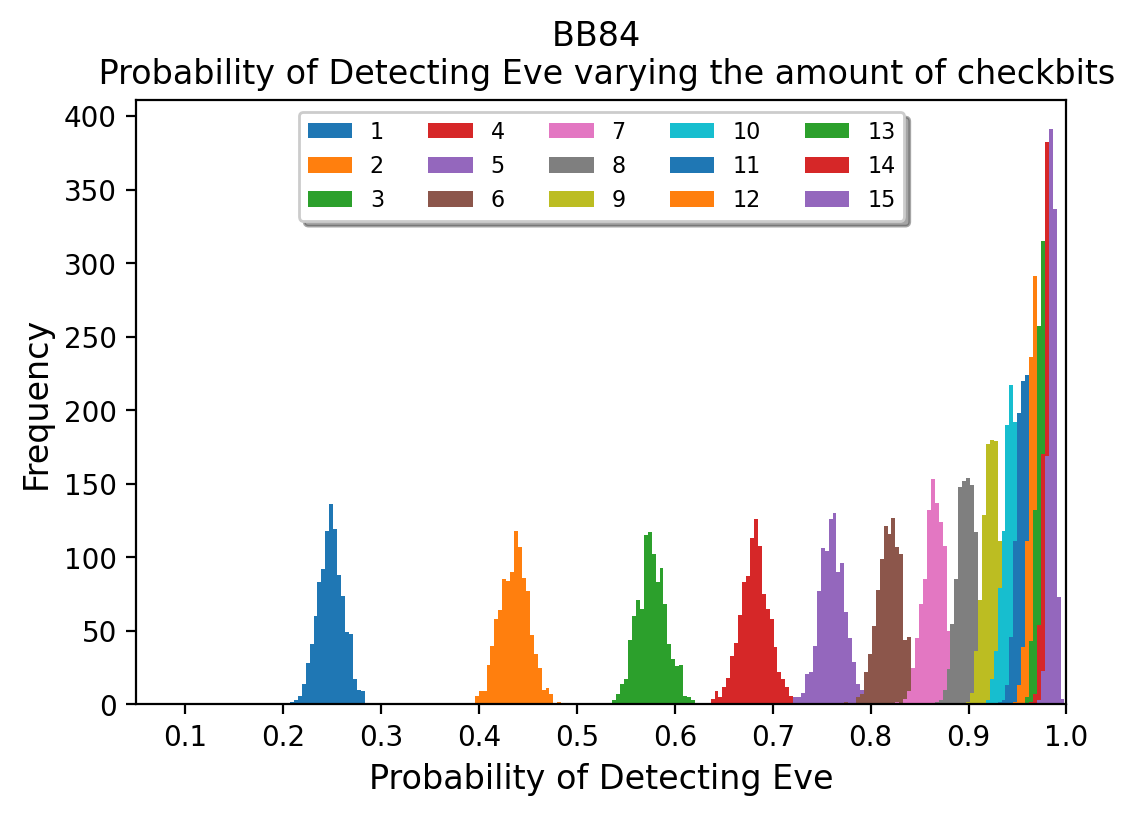

In [199]:
plt.figure(dpi=200)
df.plot(kind='hist',fontsize=10, align='left',histtype='stepfilled' ,bins=bins,ax = plt.gca())
plt.legend(loc='upper center',ncol=5,fontsize=8,shadow=True)
plt.ylabel('Frequency',fontsize=12)
plt.xlabel('Probability of Detecting Eve', fontsize=12)
plt.xticks(np.arange(start, stop+step, 2*step))
plt.xlim(0.05,1.0)
plt.title('BB84 \n Probability of Detecting Eve varying the amount of checkbits',fontsize=12)
plt.savefig(outpath+'/'+'Pandas-Dist-Supermposed-All.png',dpi=200,format='png')
plt.show()
plt.close()

## Some of the Distributions and their average values

In [200]:
avrg2=df.mean()
avrg2

1     0.250526
2     0.437693
3     0.578709
4     0.683454
5     0.763142
6     0.822009
7     0.866799
8     0.899874
9     0.925166
10    0.944141
11    0.957511
12    0.968614
13    0.976102
14    0.982232
15    0.986593
dtype: float64

## Errors between our theoretical values and our simulation values for the probabilities of detecting Eve

In [201]:
# Root Squared error
rse=np.sqrt((avrg2-P)**2)
# print('root squared error: \n',rse)

# Difference 
Error=avrg2-P
# print("Error: \n",Error)

# Absolute Error
abserr=np.abs(avrg2-P)
# print('absolute error: \n',abserr)
# print('\nIs root squared error same as absolute error?:\n', rse==abserr)


# Percentage Error
percenterr=(abserr/P)*100
print('\n    Percentage of Error       Absolute Error')
count=1
for i,x in zip(percenterr,abserr):
    print(str(count)+') \t'+'%.4f' %i+' %'+'\t\t %.4f' %x)
    count+=1
# print(percenterr)


    Percentage of Error       Absolute Error
1) 	0.2104 %		 0.0005
2) 	0.0441 %		 0.0002
3) 	0.1010 %		 0.0006
4) 	0.0204 %		 0.0001
5) 	0.0586 %		 0.0004
6) 	0.0015 %		 0.0000
7) 	0.0326 %		 0.0003
8) 	0.0015 %		 0.0000
9) 	0.0271 %		 0.0003
10) 	0.0482 %		 0.0005
11) 	0.0265 %		 0.0003
12) 	0.0300 %		 0.0003
13) 	0.0144 %		 0.0001
14) 	0.0051 %		 0.0000
15) 	0.0044 %		 0.0000


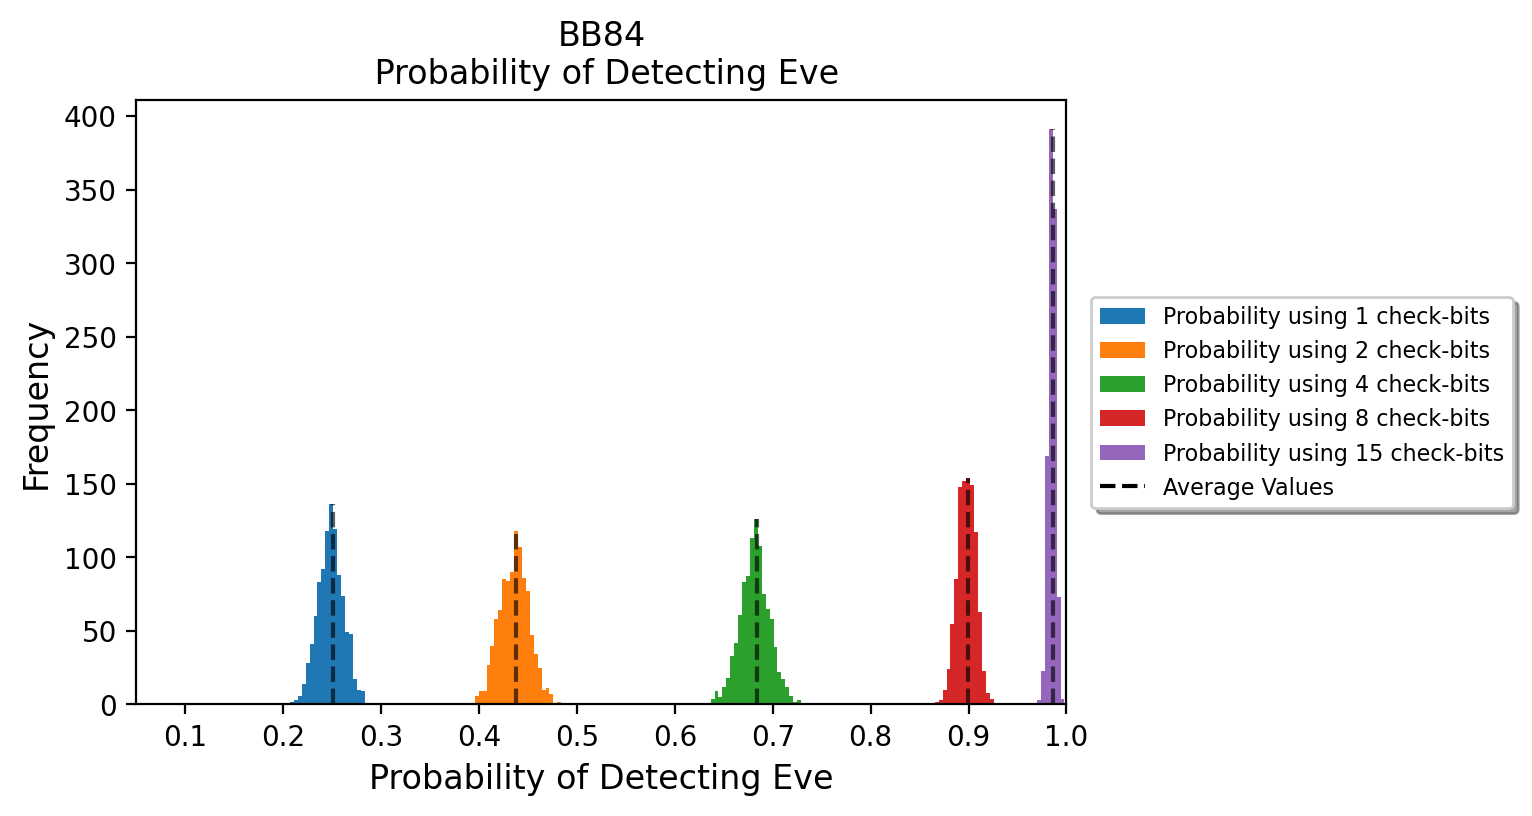

In [202]:
N2=[0,1,3,7,14] #choosing the checkbit distributions
plt.figure(dpi=200)
for qb in N2:
#     if qb==2**a[-1]:
#         count,val,_=plt.hist(df["15"],align='left',histtype='bar',label='Probability using 15 check-bits' ,bins=bins )
#     else:
    count,val,_=plt.hist(df[df.columns[qb]],align='left',histtype='bar',label='Probability using %s check-bits' %df.columns[qb],bins=bins )
    plt.vlines(x=avrg2[qb],ymin=0,ymax=max(count), colors='k', linestyles='dashed',alpha=.63)


plt.vlines(x=avrg2,ymin=0,ymax=.01, linestyles='dashed', label='Average Values')
plt.xticks(np.arange(start, stop+step, 2*step),fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Probability of Detecting Eve',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.xlim(0.05,1.0)

plt.legend(loc='center left',ncol=1,shadow=True,fontsize=8,bbox_to_anchor=(1.015,.5))
plt.title('BB84\n Probability of Detecting Eve' , fontsize=12)
plt.savefig(outpath+'/'+'Pandas-BB84-dist-superimposed.png',dpi=200,bbox_inches="tight")
plt.show()
plt.close()